In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
plt.rcParams['figure.figsize'] = (10,10)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import seaborn as sns

In [5]:
from training_utils import iterative_pruning
from training_utils import initializer

Set Seeds

In [6]:
import tensorflow as tf
import tensorflow_addons as tfa

In [7]:
seed = 7531
np.random.seed(seed)
tf.random.set_seed(seed)

In [8]:
import matplotlib

In [9]:
np.where(np.linspace(-0.3,0.3,1001) == 0)

(array([500]),)

In [10]:
gnbu_b = plt.get_cmap("GnBu")(np.linspace(-0.3,0.3,1001))
gnbu_b[500,:] = np.array([0.,0.,0.,1.])
cmap = matplotlib.colors.ListedColormap(gnbu_b)

### Tensorflow

In [11]:
import tensorflow as tf
#import tensorflow_probability as tfp
from tensorflow.keras import layers

In [12]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


Masking: https://stackoverflow.com/questions/38278965/selectively-zero-weights-in-tensorflow

In [12]:
import tensorflow_datasets as tfds

In [14]:
(ds_train_mnist, ds_test_mnist), ds_info_mnist = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [13]:
#with tf.device('/CPU:0'):
(ds_train_cif10, ds_test_cif10), ds_info_cif10 = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True, #True
    as_supervised=True,
    with_info=True,
)

In [14]:
def global_contrast_normalization(filename, s, lmda, epsilon):
    X = np.array(Image.open(filename))

    # replacement for the loop
    X_average = np.mean(X)
    print('Mean: ', X_average)
    X = X - X_average

    # `su` is here the mean, instead of the sum
    contrast = np.sqrt(lmda + numpy.mean(X**2))

    X = s * X / max(contrast, epsilon)

    # scipy can handle it
    scipy.misc.imsave('result.jpg', X)


#global_contrast_normalization("cat.jpg", 1, 10, 0.000000001)

def tf_cov(x):
    mean_x = tf.squeeze(tf.math.reduce_mean(x, axis=0, keepdims=True))
    mx = tf.matmul(tf.transpose(mean_x), mean_x)
    vx = tf.matmul(tf.transpose(x), x)/tf.cast(tf.shape(x)[0], tf.float32)
    cov_xx = vx - mx
    return cov_xx

def zca_whitening_matrix_tf(X):
    
    sigma = tf_cov(X)
    U,S,V = tf.linalg.svd(sigma)
    
    epsilon = 1e-5
    
    a = tf.math.sqrt(S + epsilon)
    a_diag = tf.linalg.diag(1.0/a)
    
    b = tf.tensordot(a_diag, tf.transpose(U))
    
    zca_matrix = tf.tensordot(U, b)
    
    return zca_matrix

def zca_whitening_matrix(X):
    """
    Function to compute ZCA whitening matrix (aka Mahalanobis whitening).
    INPUT:  X: [M x N] matrix.
        Rows: Variables
        Columns: Observations
    OUTPUT: ZCAMatrix: [M x M] matrix
    """
    #X = X.numpy()
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X, rowvar=True) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,V = np.linalg.svd(sigma)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-5
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    return ZCAMatrix #tf.convert_to_tensor(ZCAMatrix)

def zca_whitening(image):
    ZCAMatrix = zca_whitening_matrix_tf(image) # get ZCAMatrix
    return tf.matmul(ZCAMatrix, image)# np.dot(ZCAMatrix, X)

- https://arxiv.org/pdf/1511.07289.pdf
- https://arxiv.org/pdf/1302.4389.pdf
- https://cs231n.github.io/neural-networks-2/
- https://datascience.stackexchange.com/questions/15110/how-to-implement-global-contrast-normalization-in-python
- https://stackoverflow.com/questions/31528800/how-to-implement-zca-whitening-python

In [15]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True, samplewise_center=True,
    featurewise_std_normalization=False, samplewise_std_normalization=True,
    zca_whitening=True, zca_epsilon=1e-06
)
#@tf.function
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.cast(image, tf.float32)
    #image = image - tf.reduce_mean(image)
    #image = image / 255.
    #image = img_gen.flow(image, y=label)
    image = tf.image.per_image_standardization(image)
    #image = tf.pad(image, paddings=[[2, 2], [2, 2],[0, 0]])
    #image = zca_whitening(image)
    return image, tf.one_hot(label,10)

def subtract_mean(image, label):
    return image - tf.reduce_mean(image), label

#@tf.function
#@tf.autograph.experimental.do_not_convert
def prep_data(ds, ds_info):
    #ds = ds.map(subtract_mean, num_parallel_calls = tf.data.experimental.AUTOTUNE)
    #ds = ds.map(lambda img, label: img_gen.fit(img, label))
    ds = ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.cache()
    #ds = ds.shuffle(ds_info.splits['train'].num_examples)
    ds = ds.batch(128)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds
#ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#ds_train = ds_train.cache()
#ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
#ds_train = ds_train.batch(128)
#ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

#ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#ds_test = ds_test.cache()

#ds_test = ds_test.shuffle(ds_info.splits['train'].num_examples)
#ds_test = ds_test.batch(128)
#ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [16]:
ds_train_mnist = prep_data(ds_train_mnist, ds_info_mnist)
ds_test_mnist = prep_data(ds_test_mnist, ds_info_mnist)

NameError: name 'ds_train_mnist' is not defined

In [17]:
tf.math.reduce_std(iter(ds_train_mnist).next()[0])

NameError: name 'ds_train_mnist' is not defined

In [18]:
tf.math.reduce_mean(iter(ds_train_mnist).next()[0])

NameError: name 'ds_train_mnist' is not defined

In [16]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True, samplewise_center=True,
    featurewise_std_normalization=False, samplewise_std_normalization=True,
    zca_whitening=True, zca_epsilon=1e-06
)

In [17]:
#with tf.device('/CPU:0'):
ds_train_cif10 = prep_data(ds_train_cif10, ds_info_cif10)
ds_test_cif10 = prep_data(ds_test_cif10, ds_info_cif10)

In [18]:
tf.math.reduce_std(iter(ds_train_cif10).next()[0])

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [19]:
tf.math.reduce_mean(iter(ds_train_cif10).next()[0])

<tf.Tensor: shape=(), dtype=float32, numpy=9.546056e-09>

# CNN

[(W−K+2P)/S]+1

In [20]:
init = initializer()

initializer


In [21]:
from custom_nn import MaskedConv2D, MaxPool2DExt, Conv2_Mask, Conv4_Mask

In [22]:
from custom_nn import Dense_Mask

In [23]:
INPUT_SHAPE = iter(ds_train_cif10).next()[0].numpy().shape
SIGMOID_MULTIPLIER = [.1,.1,.2,.2,.2]

In [24]:
INPUT_SHAPE

(128, 32, 32, 3)

In [25]:
INPUT_SHAPE = (128, 32, 32, 3)
SIGMOID_MULTIPLIER = [.2,.2,.2, 0.2, 0.2 ,.17,.13]

<a id='trainer'>Trainer</a>

In [26]:
from IPython import display
import time

In [27]:
class ModelTrainer():
    def __init__(self, model, ds_train, ds_test, optimizer_args={}):
        self.model = model
        
        
        #self.no_params = tf.concat([tf.reshape(w, [-1]) for w in conv2_mask.trainable_weights], axis=-1).shape[0]
        
        self.loss_fn = tf.keras.losses.CategoricalCrossentropy()
        
        if optimizer_args["optimizer"] == "sgd":
            self.optimizer = tf.keras.optimizers.SGD(learning_rate=optimizer_args["lr"], momentum=optimizer_args["momentum"], nesterov=optimizer_args["nesterov"])
        elif optimizer_args["optimizer"] == "sgdw":
            self.optimizer = tfa.optimizers.SGDW(learning_rate=optimizer_args["lr"], momentum=optimizer_args["momentum"], nesterov=optimizer_args["nesterov"], weight_decay=optimizer_args["weight_decay"])
        elif optimizer_args["optimizer"] == "adam":
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=optimizer_args["lr"])
        elif optimizer_args["optimizer"] == "adamw":
            self.optimizer = tfa.optimizers.AdamW(learning_rate=optimizer_args["lr"], weight_decay=optimizer_args["weight_decay"])
        elif optimizer_args["optimizer"] == "rmsprop":
            self.optimizer = tf.keras.optimizers.RMSprop(learning_rate=optimizer_args["lr"], momentum=optimizer_args["momentum"], centered=optimizer_args["centered"])
        
        self.ds_train = ds_train
        self.ds_test = ds_test
        
        self.mask_history = []
        self.loss_history = []
        self.acc_history = []
        
        self.loss_metric = tf.keras.metrics.Mean()
        self.acc_metric = tf.keras.metrics.CategoricalAccuracy()
        
        self.current_test_acc = 1.
        self.current_test_precision = 1.
        self.current_test_recall = 1.
        self.current_test_loss = 1.
        
        self.current_one_ratio = 1.
        
    @tf.function
    def train_step(self, x_batch, y_batch):
        with tf.GradientTape(watch_accessed_variables=True) as tape:
            
            predicted = self.model(x_batch, training=True) #, weight_grad=False
            loss = self.loss_fn(y_batch, predicted)
            #loss_l2 = tf.add_n([tf.nn.l2_loss(v) for v in self.model.trainable_variables]) * 1e-5
            #loss = self.loss_fn(y_batch, predicted) + loss_l2
        
            gradients = tape.gradient(loss, self.model.trainable_variables)
        #if tf.math.is_nan(self.model.trainable_variables[0]).numpy().any() is True:
        gradients = [tf.clip_by_norm(g, 2.0) for g in gradients]

        #print([grad.get_shape() for grad in gradients])#import pdb; pdb.set_trace()
        #print([tf.math.reduce_sum(grad).numpy() for grad in gradients])
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        return loss, predicted
    
    #@tf.function
    def train_step_weights(self, x_batch, y_batch):
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(self.model.non_trainable_variables)
            
            predicted = self.model(x_batch, training=True)
            loss = self.loss_fn(y_batch, predicted)
            
            gradients = tape.gradient(loss, self.model.non_trainable_variables)
        #print([tf.math.reduce_sum(grad).numpy() for grad in gradients])
        self.optimizer.apply_gradients(zip(gradients, self.model.non_trainable_variables))
        
        return loss, predicted
    
    @tf.function
    def train_step_allen(self, x_batch, y_batch):
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(self.model.non_trainable_variables)
            
            predicted = self.model(x_batch, training=True, weight_grad=True)
            loss = self.loss_fn(y_batch, predicted)
            
            gradients = tape.gradient(loss, self.model.non_trainable_variables)

            #import pdb; pdb.set_trace()
        #print(gradients)
        #print([tf.reduce_mean(grad).numpy() for grad in gradients])
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        return loss, predicted
        
        
    #@tf.function
    def calc_ones_ratio(self):
        
        global_no_ones = np.sum([np.sum(np.abs(layer.tanh_score_mask())) for layer in self.model.layers if layer.type == "fefo" or layer.type == "conv"])
        global_size = np.sum([tf.size(layer.mask) for layer in self.model.layers if layer.type == "fefo" or layer.type == "conv"])

        remaining_ones_ratio = (global_no_ones/global_size)*100
        print(f"{remaining_ones_ratio:.2f}% of weights are 'remaining' --- total weights: {global_size}, total weights left: {global_no_ones}")
        
        self.current_one_ratio = remaining_ones_ratio
        
        #global_no_ones = self.model.no_ones
        
        #ones_ratio = tf.divide(self.model.no_ones, self.no_params)
        
        #global_no_ones = tf.reduce_sum([tf.reduce_sum(layer.get_bernoulli_mask()) for layer in self.model.layers if layer.type == "fefo" or layer.type == "conv"])
        #global_size = tf.reduce_sum([tf.size(layer.get_bernoulli_mask()) for layer in self.model.layers if layer.type == "fefo" or layer.type == "conv"])
        
        #tf.print(global_no_ones)
        #tf.print(global_size)

        #remaining_ones_ratio = (tf.cast(global_no_ones, tf.float32)/tf.cast(global_size, tf.float32))*100.0
        #tf.print(remaining_ones_ratio)
        #tf.print(f"{remaining_ones_ratio:.2f}% of weights are 'remaining'")
        
    def train_visualize(self):
        for step, (x_batch_train, y_batch_train) in enumerate(self.ds_train):
            
            with tf.GradientTape() as tape:
                tape.watch(self.model.non_trainable_variables)
                
                predicted = self.model(x_batch_train, training=True, weight_grad=True)
                loss = self.loss_fn(y_batch_train, predicted)
                
                gradients = tape.gradient(loss, self.model.non_trainable_variables)
                plt.clf()
                for i, grad in enumerate(gradients):
                    plt.figure(figsize=(18,7))
                    plt.subplot(1,len(gradients), i+1)
                    plt.hist(gradients[0].numpy().flatten(), bins=100)
                plt.show()
                display.display(plt.gcf())
            
                display.clear_output(wait=True)
                time.sleep(1)
    
    def sign_initializer(self):
        
        gradient_history = []
        

        for step, (x_batch_train, y_batch_train) in enumerate(self.ds_train):

            with tf.GradientTape(watch_accessed_variables=False) as tape:
                tape.watch(self.model.non_trainable_variables)

                predicted = self.model(x_batch_train, training=True, weight_grad=True)
                loss = self.loss_fn(y_batch_train, predicted)

            gradients = tape.gradient(loss, self.model.non_trainable_variables)
            #print(len(gradients))
            print([tf.norm(grad).numpy() for grad in gradients])
            if step == 0:
                gradient_history = gradients
            else:
                for i,grad in enumerate(gradients):
                    #print(i,grad.shape)
                    gradient_history[i] += grad
        
        gradient_history = [tf.sign(grad) for grad in gradient_history]
        
        #gradient_history = [tf.where(grad == 0., 1., grad) for grad in gradient_history]
        
        correct_layer_counter = 0
        
        for layer in self.model.layers:
            if layer.type is "fefo" or layer.type is "conv":
                #print(i, layer.type, gradient_history[i].shape)
                layer.update_weight_sign(gradient_history[correct_layer_counter])
                correct_layer_counter += 1
        
        print("Weight signs changed!")

    def train(self, epochs, supermask=True, allen=False, sign_initializer=False, logging_interval=5, pre_train=False):
        if supermask is True:
            
            if pre_train:
                for i in range(5):
                    for step, (x_batch_train, y_batch_train) in enumerate(self.ds_train):                    
                        loss, predicted = self.train_step_weights(x_batch_train, y_batch_train)

                        self.loss_metric(loss)
                        self.acc_metric(y_batch_train,predicted)

                        self.loss_history.append(self.loss_metric.result().numpy())
                        self.acc_history.append(self.acc_metric.result().numpy())
                
                    print(f"End of pretraining Epoch {i+1}. Accuracy = {self.acc_metric.result().numpy():.6f} --- Mean Loss = {self.loss_metric.result().numpy():.6f}")
                    #self.calc_ones_ratio()
                    self.evaluate()
                
                    self.loss_metric.reset_states()
                    self.acc_metric.reset_states()
            
            self.calc_ones_ratio()
            for epoch in range(epochs):
                for step, (x_batch_train, y_batch_train) in enumerate(self.ds_train):
                    
                    #if allen is False:
                    loss, predicted = self.train_step(x_batch_train, y_batch_train)
                    #else:
                    #    loss, predicted = self.train_step_allen(x_batch_train, y_batch_train)
                    
                    self.loss_metric(loss)
                    self.acc_metric(y_batch_train,predicted)
                
                
                    
                
                #self.mask_history.append([layer.bernoulli_mask for layer in self.model.layers if layer.type is "conv" or layer.type is "fefo"])
                self.loss_history.append(self.loss_metric.result().numpy())
                self.acc_history.append(self.acc_metric.result().numpy())
                
                if epoch % logging_interval == 0:
                    print(f"End of Epoch {epoch+1}. Accuracy = {self.acc_metric.result().numpy():.6f} --- Mean Loss = {self.loss_metric.result().numpy():.6f}")
                    self.calc_ones_ratio()
                    self.evaluate()
                
                self.loss_metric.reset_states()
                self.acc_metric.reset_states()
            
            self.evaluate()

        else:
            for epoch in range(epochs):
                for step, (x_batch_train, y_batch_train) in enumerate(self.ds_train):
                    loss, predicted = self.train_step(x_batch_train, y_batch_train)

                    self.loss_metric(loss)
                    self.acc_metric(y_batch_train,predicted)

                self.loss_history.append(self.loss_metric.result().numpy())
                self.acc_history.append(self.acc_metric.result().numpy())
                
                if epoch % logging_interval == 0:
                    print(f"End of Epoch: {epoch+1}: Accuracy = {self.acc_metric.result().numpy():.6f} --- Mean Loss = {self.loss_metric.result().numpy():.6f}")
                    self.evaluate()
                    
                self.loss_metric.reset_states()
                self.acc_metric.reset_states()
    
    #@tf.function
    #def evaluate_step(self,eval_acc, eval_loss_mean, eval_loss_fn):

    #    for x_batch_test, y_batch_test in self.ds_test:
    #        eval_pred = self.model(x_batch_test, training=False)
    #        eval_loss = eval_loss_fn(y_batch_test, eval_pred)

    #        eval_loss_mean(eval_loss)
    #        eval_acc(y_batch_test, eval_pred)
        
    #    return eval_acc.result(), eval_loss_mean.result()

            
    def evaluate(self):
        eval_acc = tf.keras.metrics.CategoricalAccuracy()
        eval_precision = tf.keras.metrics.Precision()
        eval_recall = tf.keras.metrics.Recall()
        eval_loss_mean = tf.keras.metrics.Mean()
        eval_loss_fn = tf.keras.losses.CategoricalCrossentropy()
        
        for x_batch_test, y_batch_test in self.ds_test:
            eval_pred = self.model(x_batch_test, training=False)
            eval_loss = eval_loss_fn(y_batch_test, eval_pred)

            eval_loss_mean(eval_loss)
            eval_acc(y_batch_test, eval_pred)
            #eval_precision(y_batch_test, eval_pred)
            #eval_recall(y_batch_test, eval_pred)
        #eval_acc, eval_loss_mean = self.evaluate_step(eval_acc, eval_loss_mean, eval_loss_fn)
        
        self.current_test_acc = eval_acc.result().numpy()
        #self.current_test_precision = eval_precision.result().numpy()
        #self.current_test_recall = eval_recall.result().numpy()
        self.current_test_loss = eval_loss_mean.result().numpy()
        
        print("Evaluation Loss: ", self.current_test_loss, " Accuracy: ", self.current_test_acc)
        #print("Evaluation Loss: ", self.current_test_loss, " Accuracy: ", self.current_test_acc, " Precision: ", self.current_test_precision, " Recall: ", self.current_test_recall)
        
        #self.current_test_acc = eval_acc.result().numpy()
        #self.current_test_loss = eval_loss_mean.result().numpy()
        #print(f"Evaluation Loss: {eval_loss_mean.result().numpy()}")
        #print(f"Evaluation Accuracy: {eval_acc.result().numpy()}")

[To Mask Training](#mask_training)  
[To Masked Model](#masked_model)

## Baseline

In [41]:
from custom_nn import Conv2, Conv4, Conv6

In [42]:
baseline_model = Conv4(use_bias=False)

In [289]:
output = baseline_model(iter(ds_train_cif10).next()[0]).numpy()
output

array([[0.09964702, 0.07516973, 0.12707345, ..., 0.08192022, 0.06999229,
        0.14020652],
       [0.03884891, 0.07871229, 0.11108594, ..., 0.01980937, 0.043242  ,
        0.03721317],
       [0.03295748, 0.11231609, 0.21083024, ..., 0.02231494, 0.1329914 ,
        0.04843933],
       ...,
       [0.09156259, 0.10438701, 0.03092851, ..., 0.02604475, 0.11213196,
        0.20235257],
       [0.10134277, 0.11429573, 0.0694112 , ..., 0.22842367, 0.06144198,
        0.10750769],
       [0.04319856, 0.07036653, 0.09523336, ..., 0.17307314, 0.01886704,
        0.1686264 ]], dtype=float32)

In [290]:
baseline_model.layers[-1].get_weights()

[array([[-1.05627432e-01,  1.34933800e-01,  1.15302444e-01, ...,
          4.49681878e-02,  2.03956664e-03,  1.22471631e-01],
        [-1.33749098e-01,  9.57584381e-02,  1.18046910e-01, ...,
          1.14255667e-01, -1.78212523e-02, -7.61511102e-02],
        [ 1.28822088e-01, -6.89586550e-02, -7.55341426e-02, ...,
          7.35626519e-02, -1.91639960e-02, -4.67584953e-02],
        ...,
        [ 1.03116035e-05, -1.38846844e-01, -1.22549236e-01, ...,
          3.58713120e-02, -1.92125142e-03,  2.60483921e-02],
        [-4.01359573e-02, -7.30157271e-02,  1.33845121e-01, ...,
         -3.64975855e-02, -8.27998593e-02, -6.98115230e-02],
        [-1.90120935e-03,  1.22442365e-01,  1.50065929e-01, ...,
         -6.23042136e-02,  4.61670607e-02, -1.49424642e-01]], dtype=float32)]

In [285]:
layer_shapes = []
for layer in baseline_model.layers:
    if layer.type == "conv_normal" or layer.type == "fefo_normal":
        shape = layer.get_weights()[0].shape
        layer_shapes.append(shape)
layer_shapes

IndexError: list index out of range

In [239]:
init = initializer()

initializer


In [240]:
MU=0
MU_BI = [-0.13, 0.13]
SIGMA=-3 #0.1 IF SIGMA == -1 --> glorot normal
SIGMA_BI = [-SIGMA, SIGMA]
conv2, initial_weights = init.set_weights_man(baseline_model, mode="uniform", constant=-2, mu=MU, sigma=-8, factor=1./np.sqrt(3), mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="", weight_as_constant=False, set_mask=False, layer_shapes=layer_shapes) # uniform -3 1./np.sqrt(2)
#fcn, initial_weights = init.set_weights_man(fcn, mode="normal", mu=MU, sigma=SIGMA, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="./weights/initial_weights", weight_as_constant=True)_mas

Glorot uniform with bound 0.2722
Glorot uniform with bound 0.0589
Glorot uniform with bound 0.0589
Glorot uniform with bound 0.0417
Glorot uniform with bound 0.0156
Glorot uniform with bound 0.0884
Glorot uniform with bound 0.0884


In [241]:
optimizer_args = {}
optimizer_args["optimizer"] = "sgdw"
optimizer_args["lr"] = .01 #* schedule(step)
optimizer_args["weight_decay"] = 5e-4 #* schedule(step)
optimizer_args["momentum"] = 0.9
optimizer_args["nesterov"] = True

mt = ModelTrainer(baseline_model, ds_train_cif10, ds_test_cif10, optimizer_args=optimizer_args)

In [242]:
mt.train(100, supermask=False, logging_interval=10)

End of Epoch: 1: Accuracy = 0.559440 --- Mean Loss = 1.242206
Evaluation Loss:  0.9913928  Accuracy:  0.6552
End of Epoch: 11: Accuracy = 0.939620 --- Mean Loss = 0.175771
Evaluation Loss:  1.1361537  Accuracy:  0.7202
End of Epoch: 21: Accuracy = 0.963820 --- Mean Loss = 0.111565
Evaluation Loss:  1.0741371  Accuracy:  0.7349
End of Epoch: 31: Accuracy = 0.966560 --- Mean Loss = 0.104540
Evaluation Loss:  1.0399877  Accuracy:  0.7328
End of Epoch: 41: Accuracy = 0.975000 --- Mean Loss = 0.086738
Evaluation Loss:  1.021117  Accuracy:  0.7309
End of Epoch: 51: Accuracy = 0.976800 --- Mean Loss = 0.079695
Evaluation Loss:  1.0382355  Accuracy:  0.7288
End of Epoch: 61: Accuracy = 0.966480 --- Mean Loss = 0.102227
Evaluation Loss:  1.0681673  Accuracy:  0.7326
End of Epoch: 71: Accuracy = 0.976500 --- Mean Loss = 0.079195
Evaluation Loss:  1.0310056  Accuracy:  0.7399
End of Epoch: 81: Accuracy = 0.975920 --- Mean Loss = 0.081036
Evaluation Loss:  1.0446597  Accuracy:  0.7327
End of Epoch

In [243]:
mt.evaluate()

Evaluation Loss:  1.020729  Accuracy:  0.7332


In [244]:
baseline_weights = mt.model.get_weights()

# Masked
<a id='masked_model'></a>

In [113]:
model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, 3, padding='same', name='conv2D_1', input_shape=INPUT_SHAPE[1:], kernel_initializer="he_uniform"),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Conv2D(64, 3, padding='same', name='conv2D_2', kernel_initializer="he_uniform"),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D((2, 2), (2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation="relu", name='fc_1', kernel_initializer="he_uniform"),
        tf.keras.layers.Dense(256, activation="relu", name='fc_2', kernel_initializer="he_uniform"),
        tf.keras.layers.Dense(10, activation=None,name='fc_3', kernel_initializer="he_uniform")
])
model.build()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2D_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2D_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_3 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
fc_1 (Dense)                 (None, 256)              

Constant with:  0.4714045207910316  
Constant with:  0.10206207261596574  
Constant with:  0.019136638615493577  
Constant with:  0.15309310892394862  
Constant with:  0.15309310892394862  

In [123]:
a = np.random.randn(1000)

In [132]:
np.var(a[500:])

0.924624093931922

In [127]:
a[:500] = 0

In [116]:
np.std(model.trainable_weights[0].numpy().flatten())

0.28002805

In [114]:
for w in model.trainable_weights:
    print(np.max(w.numpy().flatten()))

0.47135285
0.0
0.102052495
0.0
0.01913662
0.0
0.15309282
0.0
0.15301116
0.0


In [133]:
model = None

In [44]:
from custom_nn import Conv2_Mask, Conv4_Mask, Conv6_Mask, Conv8_Mask, VGG19_Mask
from training_utils import initializer

In [45]:
INPUT_SHAPE = iter(ds_train_cif10).next()[0].numpy().shape #(128, 32, 32, 3)
SIGMOID_MULTIPLIER = [.25,.23,.21,.17,.13] #[1.,1.,1.,1.,1.]#
SIGMOID_MULTIPLIER_4 = [.25,.23,.21,.17,.13,.13,.13,.13,.13,.13] #[1.,1.,1.,1.,1.]#
SIGMOID_MULTIPLIER_6 = [.21,.19,.17,.15,.11,.11,.11,.11,.11,.11]
SM = [0.05] * 10
ALLEN_MULTIPLIER = [1.] * 10

In [46]:
conv2_mask = Conv4_Mask(input_shape=INPUT_SHAPE, sigmoid_multiplier=SIGMOID_MULTIPLIER_4, use_bias=False,#SIGMOID_MULTIPLIER_4, #use_dropout=False, 
                        dynamic_scaling_cnn=False, dynamic_scaling_dense=True, k_cnn=0.3, k_dense=0.3)

In [94]:
conv2_mask.layers[-1].sigmoid_mask()

<tf.Tensor: shape=(256, 10), dtype=float32, numpy=
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.],
       ...,
       [1., 0., 1., ..., 1., 1., 0.],
       [0., 1., 0., ..., 1., 0., 1.],
       [1., 1., 1., ..., 0., 1., 0.]], dtype=float32)>

In [265]:
layer_counter = 0
for i,layer in enumerate(conv2_mask.layers):
    if layer.type is "fefo" or layer.type is "conv":
        layer.set_normal_weights(baseline_weights[layer_counter])
        layer_counter += 1

In [63]:
conv2_mask = None

In [208]:
tf.keras.initializers.GlorotUniform()(shape=(5,))

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 0.41975272,  0.5334902 , -0.42549333, -0.4070569 , -0.5917726 ],
      dtype=float32)>

In [47]:
for layer in conv2_mask.layers:
    if layer.type == "fefo" or layer.type == "conv":
        print("Output Shape: ", layer.out_shape)

Output Shape:  (128, 32, 32, 64)
Output Shape:  (128, 32, 32, 64)
Output Shape:  (128, 16, 16, 128)
Output Shape:  (128, 16, 16, 128)
Output Shape:  (None, 256)
Output Shape:  (None, 256)
Output Shape:  (None, 10)


In [48]:
tw_shapes = []
for l in conv2_mask.trainable_weights:
    tw_shapes.append(l.get_shape())
tw_shapes

[TensorShape([3, 3, 3, 64]),
 TensorShape([3, 3, 64, 64]),
 TensorShape([3, 3, 64, 128]),
 TensorShape([3, 3, 128, 128]),
 TensorShape([8192, 256]),
 TensorShape([256, 256]),
 TensorShape([256, 10])]

In [49]:
tw_shapes = []
for l in conv2_mask.non_trainable_weights:
    tw_shapes.append(l.get_shape())
    print("size: ", tf.size(l))
#'tw_shapes

size:  tf.Tensor(1728, shape=(), dtype=int32)
size:  tf.Tensor(36864, shape=(), dtype=int32)
size:  tf.Tensor(73728, shape=(), dtype=int32)
size:  tf.Tensor(147456, shape=(), dtype=int32)
size:  tf.Tensor(2097152, shape=(), dtype=int32)
size:  tf.Tensor(65536, shape=(), dtype=int32)
size:  tf.Tensor(2560, shape=(), dtype=int32)


In [62]:
conv2_mask.non_trainable_weights[0].shape

TensorShape([3, 3, 3, 64])

In [58]:
init = initializer()

initializer


In [100]:
for w in conv2_mask.trainable_weights:
    shape = w.numpy().shape
    print(init.get_fans(shape))

(27.0, 576.0)
(576.0, 576.0)
(576.0, 1152.0)
(1152.0, 1152.0)
(8192.0, 256.0)
(256.0, 256.0)
(256.0, 10.0)


In [72]:
output = conv2_mask(iter(ds_train_cif10).next()[0]).numpy()
output

array([[4.4516205e-06, 3.7458625e-01, 3.2038228e-31, ..., 2.2119357e-14,
        3.6180865e-02, 5.8922827e-01],
       [6.7990709e-07, 3.1723669e-03, 4.3459289e-34, ..., 3.1541462e-18,
        7.1282131e-09, 9.9682695e-01],
       [1.2521263e-05, 1.6059961e-02, 2.1188318e-28, ..., 7.3828747e-14,
        4.4015261e-10, 9.8392755e-01],
       ...,
       [9.0884865e-15, 3.6865480e-09, 0.0000000e+00, ..., 1.8512956e-17,
        1.0000000e+00, 3.5204770e-11],
       [2.0230940e-04, 2.0512810e-03, 4.9619671e-35, ..., 9.4259995e-14,
        4.4432380e-10, 9.9774629e-01],
       [9.9814200e-01, 5.9810285e-05, 1.3121203e-34, ..., 1.2591210e-14,
        1.0441408e-10, 1.7980875e-03]], dtype=float32)

In [51]:
init = initializer()

initializer


In [52]:
MU=0
MU_BI = [-0.13, 0.13]
SIGMA=-3 #0.1 IF SIGMA == -1 --> glorot normal
SIGMA_BI = [-SIGMA, SIGMA]
conv2_mask, initial_weights = init.set_weights_man(conv2_mask, mode="signed_constant", constant=-2, mu=MU, sigma=-8, factor=1./np.sqrt(2), mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="", weight_as_constant=True, set_mask=False) # uniform -3 1./np.sqrt(2)
#fcn, initial_weights = init.set_weights_man(fcn, mode="normal", mu=MU, sigma=SIGMA, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="./weights/initial_weights", weight_as_constant=True)_mas

Signed constant (std): 0.33333333333333326
Signed constant (std): 0.0721687836487032
Signed constant (std): 0.0721687836487032
Signed constant (std): 0.05103103630798287
Signed constant (std): 0.019136638615493574
Signed constant (std): 0.10825317547305481
Signed constant (std): 0.10825317547305481


In [53]:
conv2_mask, initial_weights_mask = init.set_weights_man(conv2_mask, mode="normal", constant=-2, mu=MU, sigma=-8, factor=1./np.sqrt(2), mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="", weight_as_constant=False, set_mask=True) #1./np.sqrt(2)

Glorot normal with sigma 0.3333
Glorot normal with sigma 0.0722
Glorot normal with sigma 0.0722
Glorot normal with sigma 0.0510
Glorot normal with sigma 0.0191
Glorot normal with sigma 0.1083
Glorot normal with sigma 0.1083


In [57]:
k = .3

In [54]:
thmfg = tf.gather(tf.reshape(conv2_mask.layers[-2].mask, -1), np.arange(0,4000))

In [67]:
tf.reduce_min(thmf)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.3435466>

In [68]:
tf.reduce_max(thmf)

<tf.Tensor: shape=(), dtype=float32, numpy=0.37060565>

In [62]:
thmf = tf.random.shuffle(tf.reshape(conv2_mask.layers[-2].mask, -1)[:4000])

In [63]:
def test():
    a = tf.reduce_min(tf.nn.top_k(thmf, int(k*4000), sorted=True).values)
    b = tf.reduce_max(-tf.nn.top_k(-thmf, int(k*4000), sorted=True).values)
    return a,b

In [69]:
tf.where(thmf < b)

<tf.Tensor: shape=(1199, 1), dtype=int64, numpy=
array([[   2],
       [   5],
       [   9],
       ...,
       [3991],
       [3994],
       [3998]])>

In [64]:
a,b = test()

In [65]:
a

<tf.Tensor: shape=(), dtype=float32, numpy=0.056835055>

In [66]:
b

<tf.Tensor: shape=(), dtype=float32, numpy=-0.056839492>

In [224]:
tf.reduce_min(thmf)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.3435466>

In [225]:
-tf.nn.top_k(-thmf, int(k*4000), sorted=True).values

<tf.Tensor: shape=(1200,), dtype=float32, numpy=
array([-0.3435466 , -0.33548206, -0.3318527 , ..., -0.05701995,
       -0.05695657, -0.05683949], dtype=float32)>

In [226]:
ta, tb = test()

In [227]:
ta

<tf.Tensor: shape=(), dtype=float32, numpy=0.056835055>

In [228]:
tb

<tf.Tensor: shape=(), dtype=float32, numpy=-0.056839492>

In [229]:
%timeit test()

151 µs ± 3.27 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [217]:
thmfs = tf.sort(thmf, direction='DESCENDING')

In [218]:
tf.gather(thmfs, int(k*4000))

<tf.Tensor: shape=(), dtype=float32, numpy=0.05680875>

In [219]:
tf.gather(thmfs, int((1-k)*4000))

<tf.Tensor: shape=(), dtype=float32, numpy=-0.056839492>

In [235]:
%timeit thmfs[2]

51.3 µs ± 2.49 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [236]:
%timeit tf.gather(thmfs,2)

13.5 µs ± 242 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [230]:
def test2():
    thmfs = tf.sort(thmf)
    a = tf.gather(thmfs, int(k*4000))
    b = tf.gather(thmfs, int((1-k)*4000))
    return a,b

In [231]:
%timeit test2()

188 µs ± 2.91 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [232]:
t2a, t2b = test2()

In [272]:
conv2_mask.layers[-1].get_weights()[1]

array([[-0.00156388, -0.06424852,  0.08736442, ..., -0.03291562,
        -0.01851829,  0.05493959],
       [ 0.1499676 , -0.05822875, -0.0842545 , ..., -0.03922633,
         0.1336216 ,  0.07310622],
       [ 0.12902462, -0.06146348,  0.01918053, ...,  0.07505446,
        -0.08283897, -0.07027753],
       ...,
       [ 0.03345034, -0.00777357,  0.05012682, ..., -0.07696955,
         0.04613776,  0.02339217],
       [ 0.08897674,  0.0908137 , -0.03619693, ...,  0.09175812,
        -0.12880088,  0.08174158],
       [-0.12429196, -0.04367563,  0.09964422, ...,  0.03893014,
        -0.06091934, -0.05698461]], dtype=float32)

In [273]:
conv2_mask.layers[-1].get_normal_weights()

<tf.Variable 'w:0' shape=(256, 10) dtype=float32, numpy=
array([[-0.00156388, -0.06424852,  0.08736442, ..., -0.03291562,
        -0.01851829,  0.05493959],
       [ 0.1499676 , -0.05822875, -0.0842545 , ..., -0.03922633,
         0.1336216 ,  0.07310622],
       [ 0.12902462, -0.06146348,  0.01918053, ...,  0.07505446,
        -0.08283897, -0.07027753],
       ...,
       [ 0.03345034, -0.00777357,  0.05012682, ..., -0.07696955,
         0.04613776,  0.02339217],
       [ 0.08897674,  0.0908137 , -0.03619693, ...,  0.09175812,
        -0.12880088,  0.08174158],
       [-0.12429196, -0.04367563,  0.09964422, ...,  0.03893014,
        -0.06091934, -0.05698461]], dtype=float32)>

In [274]:
conv2_mask.layers[-1].w

<tf.Variable 'w:0' shape=(256, 10) dtype=float32, numpy=
array([[-0.00156388, -0.06424852,  0.08736442, ..., -0.03291562,
        -0.01851829,  0.05493959],
       [ 0.1499676 , -0.05822875, -0.0842545 , ..., -0.03922633,
         0.1336216 ,  0.07310622],
       [ 0.12902462, -0.06146348,  0.01918053, ...,  0.07505446,
        -0.08283897, -0.07027753],
       ...,
       [ 0.03345034, -0.00777357,  0.05012682, ..., -0.07696955,
         0.04613776,  0.02339217],
       [ 0.08897674,  0.0908137 , -0.03619693, ...,  0.09175812,
        -0.12880088,  0.08174158],
       [-0.12429196, -0.04367563,  0.09964422, ...,  0.03893014,
        -0.06091934, -0.05698461]], dtype=float32)>

In [275]:
conv2_mask.layers[-1].mask.numpy()

array([[-0.16565214, -0.31291315,  0.06012833, ...,  0.04732448,
         0.00121118,  0.13002162],
       [ 0.16313529, -0.00920927, -0.03127684, ..., -0.02995137,
        -0.04070131,  0.05358039],
       [-0.09109043, -0.04140765, -0.05026278, ..., -0.09557967,
         0.04891989, -0.06963033],
       ...,
       [ 0.16092731, -0.2006192 , -0.05122335, ..., -0.01491927,
        -0.14275727, -0.02328093],
       [-0.1782787 ,  0.03627529, -0.12325253, ...,  0.07667086,
         0.00240341, -0.0865415 ],
       [-0.10640458, -0.1406791 , -0.06880324, ..., -0.14607912,
        -0.03068731, -0.02551471]], dtype=float32)

In [276]:
for var in conv2_mask.trainable_weights:
    print(var.name)

mask:0
mask:0
mask:0
mask:0
mask:0
mask:0
mask:0


In [256]:
for layer in conv2_mask.layers:
    if layer.type == "fefo" or layer.type == "conv":
        layer.update_tanh_th(percentage=0.3)
print("Updated Threshold for tanh!")

Updated Threshold for tanh!


In [257]:
for layer in conv2_mask.layers:
    if layer.type is "fefo" or layer.type is "conv":
        print(layer.tanh_th)

tf.Tensor(0.36862206, shape=(), dtype=float32)
tf.Tensor(0.08628258, shape=(), dtype=float32)
tf.Tensor(0.09591327, shape=(), dtype=float32)
tf.Tensor(0.063482836, shape=(), dtype=float32)
tf.Tensor(0.028795624, shape=(), dtype=float32)
tf.Tensor(0.1425394, shape=(), dtype=float32)
tf.Tensor(0.10413315, shape=(), dtype=float32)


In [40]:
for layer in conv2_mask.layers:
    if layer.type == "fefo":
        print("Feed Forward with shape: ", layer.shape)
    if layer.type == "conv":
        print("Convolutional Layer with weight shape: ", layer.weight_shape)
    else:
        continue
        

Convolutional Layer with weight shape:  (3, 3, 3, 64)
Convolutional Layer with weight shape:  (3, 3, 64, 64)
Feed Forward with shape:  (16384, 256)
Feed Forward with shape:  (256, 256)
Feed Forward with shape:  (256, 10)


In [43]:
np.unique(conv2_mask.layers[-1].tanh_mask().numpy())

array([0.99999994, 1.        ], dtype=float32)

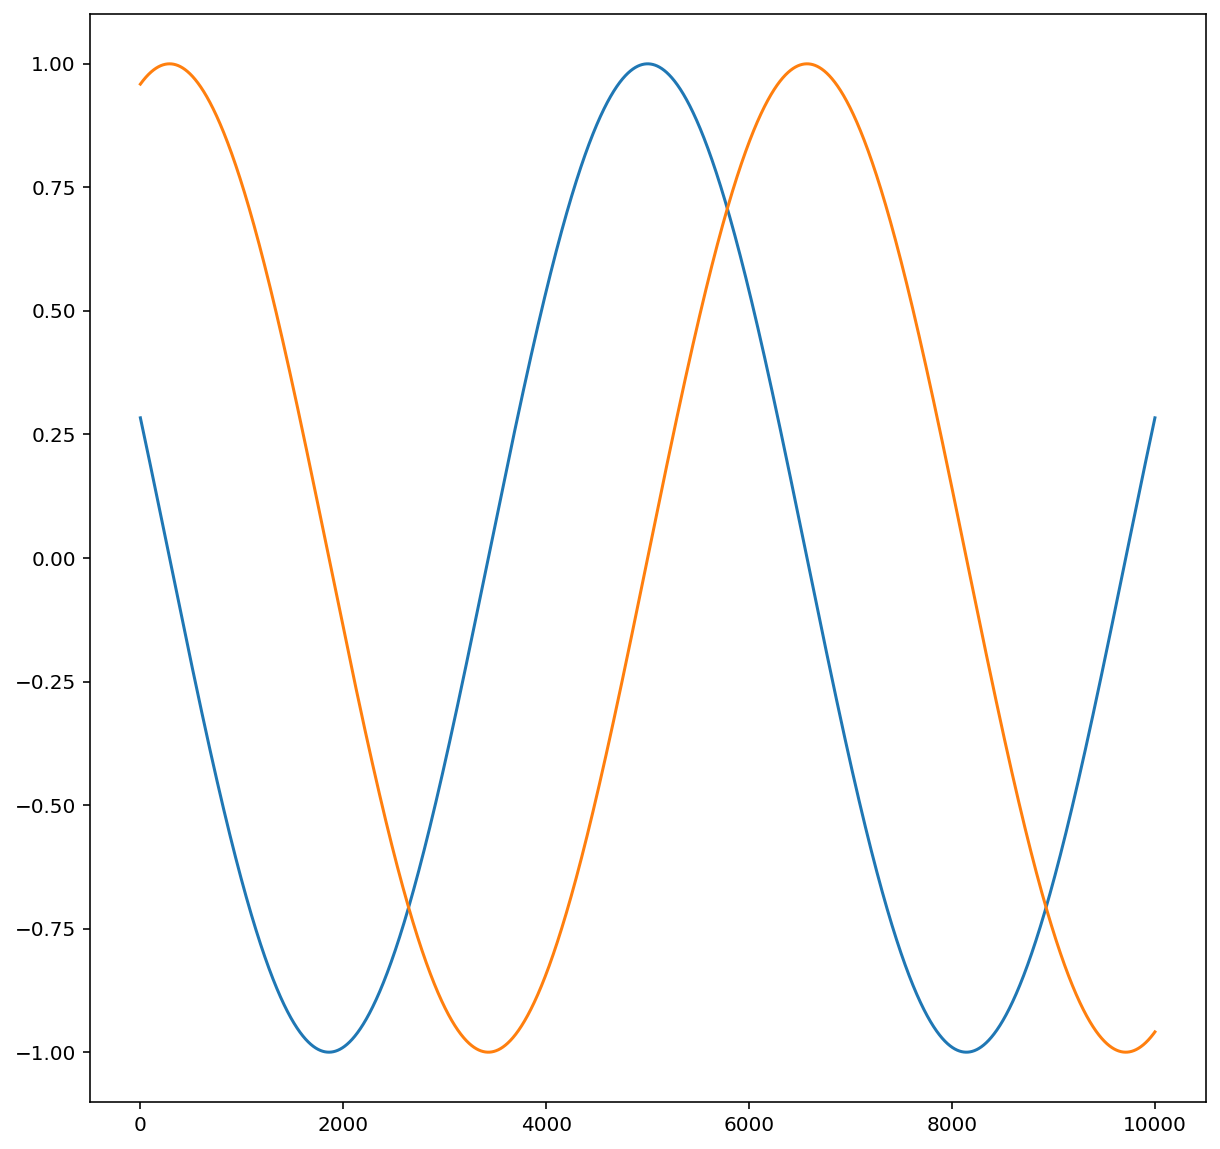

In [46]:
x = np.linspace(-5,5,10000)
plt.plot(np.cos(x))
plt.plot(np.sin(x))

In [134]:
import gc
gc.collect()

1935

In [108]:
def just_eval(model, ds_test):
    eval_acc = tf.keras.metrics.CategoricalAccuracy()
    eval_loss_mean = tf.keras.metrics.Mean()
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    for x_batch_test, y_batch_test in ds_test:
        eval_pred = model(x_batch_test)
        eval_loss = loss_fn(y_batch_test, eval_pred)

        eval_loss_mean(eval_loss)
        eval_acc(y_batch_test, eval_pred)

    print(f"Evaluation Loss: {eval_loss_mean.result().numpy()}")
    print(f"Evaluation Accuracy: {eval_acc.result().numpy()}")

[To Trainer](#trainer)  
[To Masked Model](#masked_model)
<a id='mask_training'></a>

ResNet 50: https://towardsdatascience.com/understand-and-implement-resnet-50-with-tensorflow-2-0-1190b9b52691

In [135]:
conv2_mask = None
import gc
gc.collect()

22

In [136]:
from custom_nn import Conv2_Mask, Conv4_Mask, Conv6_Mask, Conv8_Mask, VGG19_Mask

In [140]:
def repeat_experiment(conv, no_experiments=5, epochs=40, tanh_th_percentage=0.3):
    
    
    INPUT_SHAPE = iter(ds_train_cif10).next()[0].numpy().shape #(128, 32, 32, 3)
    
    pre_training = False
    
    #gain = np.sqrt(2)
    scale_fan = 3
    #gain = np.sqrt(2/(1+0.5**2)) #leaky relu gain
    #gain = np.sqrt(2) #relu gain
    gain = 1.
    
    total_gain = gain / np.sqrt(scale_fan)
    
    
    MU=0
    MU_BI = [-0.13, 0.13]
    SIGMA=-3 #0.1 IF SIGMA == -1 --> glorot normal
    SIGMA_BI = [-SIGMA, SIGMA]
    
    results = []
    
    init = initializer(seed=7531)

    steps_per_epoch = 390
    
    for i in range(no_experiments):
        
        if conv == 2:
            model = Conv2_Mask(input_shape=INPUT_SHAPE, use_bias=False, width_multiplier=1, k_cnn=.2, k_dense=.2, #use_dropout=True, dropout_rate=0.15,  sigmoid_multiplier=SIGMOID_MULTIPLIER_4,, k_cnn=0.4, k_dense=0.4
                        dynamic_scaling_cnn=False, dynamic_scaling_dense=False)
            #baseline_model = Conv2(use_bias=False)
        elif conv == 4:
            model = Conv4_Mask(input_shape=INPUT_SHAPE, width_multiplier=1., k_cnn=.25, k_dense=.25, #use_dropout=True, dropout_rate=0.1,  , sigmoid_multiplier=SIGMOID_MULTIPLIER_4 , k_cnn=0.3, k_dense=0.3
                            dynamic_scaling_cnn=False, dynamic_scaling_dense=False, use_bias=False)
            #baseline_model = Conv4(use_bias=False)
        elif conv == 6:
            model = Conv6_Mask(input_shape=INPUT_SHAPE,use_dropout=False, k_cnn=.25, k_dense=.25, #, sigmoid_multiplier=SIGMOID_MULTIPLIER_4 , k_cnn=0.3, k_dense=0.3 
                            dynamic_scaling_cnn=False, dynamic_scaling_dense=False)
            #baseline_model = Conv6(use_bias=False)
        elif conv == 8:
            model = Conv8_Mask(input_shape=INPUT_SHAPE,use_dropout=False, k_cnn=.25, k_dense=.25, #, sigmoid_multiplier=SIGMOID_MULTIPLIER_4 , k_cnn=0.3, k_dense=0.3
                            dynamic_scaling_cnn=False, dynamic_scaling_dense=False)
        elif conv == 10:
            model = VGG19_Mask(input_shape=INPUT_SHAPE,use_dropout=False, #, sigmoid_multiplier=SIGMOID_MULTIPLIER_4 , k_cnn=0.3, k_dense=0.3
                            dynamic_scaling_cnn=False, dynamic_scaling_dense=False)
            
        if pre_training:
            _ = baseline_model(iter(ds_train_cif10).next()[0])


            layer_shapes = []
            for layer in baseline_model.layers:
                if layer.type == "conv_normal" or layer.type == "fefo_normal":
                    shape = layer.get_weights()[0].shape
                    layer_shapes.append(shape)


            baseline_model, initial_weights = init.set_weights_man(baseline_model, mode="normal", constant=-2, mu=MU, sigma=-8, factor=1./np.sqrt(3), mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="", weight_as_constant=False, set_mask=False, layer_shapes=layer_shapes) 
            optimizer_args = {}
            optimizer_args["optimizer"] = "sgdw"
            optimizer_args["lr"] = .01 #* schedule(step)
            optimizer_args["weight_decay"] = 5e-4 #* schedule(step)
            optimizer_args["momentum"] = 0.9
            optimizer_args["nesterov"] = False

            mt = ModelTrainer(baseline_model, ds_train_cif10, ds_test_cif10, optimizer_args=optimizer_args)

            print("Start training Baseline model")

            mt.train(5, supermask=False, logging_interval=999)
            baseline_weights = mt.model.get_weights()

            print("Baseline model trained!")
        
        print("-------------------------------------------------------")
        print("Starting Experiment", i,"...")
        print("-------------------------------------------------------")
        
        intermediate_results = {}
        
        
        if pre_training:
            layer_counter = 0
            for i,layer in enumerate(model.layers):
                if layer.type is "fefo" or layer.type is "conv":
                    layer.set_normal_weights(baseline_weights[layer_counter])
                    layer_counter += 1
        else:
            model, initial_weights = init.set_weights_man(model, mode="constant", constant=-2, mu=MU, sigma=-8, factor=np.sqrt(2), mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="", weight_as_constant=True, set_mask=False) # uniform -3 1./np.sqrt(3)
        
        model, initial_weights_mask = init.set_weights_man(model, mode="uniform", constant=-2, mu=MU, sigma=-7, factor=np.sqrt(2), mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="", weight_as_constant=False, set_mask=True) #1./np.sqrt(2)
        print("Model initialized!")
        
        for layer in model.layers:
            if layer.type == "fefo" or layer.type == "conv":
                layer.update_tanh_th(percentage=tanh_th_percentage)
        print("Updated Threshold for tanh!")
        
        schedule = tf.keras.experimental.CosineDecay(1., 20*steps_per_epoch, alpha=0.001)#
        schedule_lr = tf.keras.optimizers.schedules.ExponentialDecay(3e-4, decay_steps=3900*2, decay_rate=0.96, staircase=True)
        schedule_wd = tf.keras.optimizers.schedules.ExponentialDecay(1e-4, decay_steps=3900*2, decay_rate=0.96, staircase=True)
        step = tf.Variable(0, trainable=False)

        optimizer_args = {}
        optimizer_args["optimizer"] = "adamw"
        optimizer_args["lr"] = schedule_lr#.001# * schedule(step)
        optimizer_args["weight_decay"] = schedule_wd #1e-4 #* schedule(step)
        optimizer_args["momentum"] = 0.9
        optimizer_args["nesterov"] = True
        # for rmsprop
        optimizer_args["centered"] = True

        mt = ModelTrainer(model, ds_train = ds_train_cif10, ds_test = ds_test_cif10, optimizer_args=optimizer_args)
        
        mt.train(epochs=epochs, allen=False, sign_initializer=False, logging_interval=10, pre_train=False)
        
        #intermediate_results["loss_history"] = mt.loss_history
        #intermediate_results["acc_history"] = mt.acc_history
        
        intermediate_results["test_acc"] = mt.current_test_acc
        intermediate_results["test_loss"] = mt.current_test_loss
        intermediate_results["ones_ratio"] = mt.current_one_ratio
        
        results.append(intermediate_results)
        
    return results, model

https://stats.stackexchange.com/questions/52646/variance-of-product-of-multiple-random-variables

In [141]:
(50000 // 128) 

390

In [143]:
results, model = repeat_experiment(conv=4, no_experiments=30, epochs=100, tanh_th_percentage=0.4)

initializer
-------------------------------------------------------
Starting Experiment 0 ...
-------------------------------------------------------
Constant with:  0.6666666666666666
Constant with:  0.14433756729740643
Constant with:  0.14433756729740643
Constant with:  0.10206207261596575
Constant with:  0.038273277230987154
Constant with:  0.21650635094610965
Constant with:  0.21650635094610965
Glorot uniform with bound 0.0998
Glorot uniform with bound 0.0722
Glorot uniform with bound 0.0589
Glorot uniform with bound 0.0510
Glorot uniform with bound 0.0267
Glorot uniform with bound 0.1083
Glorot uniform with bound 0.1502
Model initialized!
Updated Threshold for tanh!
50.02% of weights are 'remaining' --- total weights: 2425024, total weights left: 1212938.0
End of Epoch 1. Accuracy = 0.299100 --- Mean Loss = 10.829170
50.12% of weights are 'remaining' --- total weights: 2425024, total weights left: 1215309.0
Evaluation Loss:  1.7025539  Accuracy:  0.3874
End of Epoch 11. Accuracy =

KeyboardInterrupt: 

In [ ]:
np.sum([tf.size(l.mask).numpy() for l in model.layers if l.type is "conv" or l.type is "fefo"])

In [160]:
[res["test_acc"] for res in results]

[0.7796]

In [161]:
np.mean([res["test_acc"] for res in results])

0.7796

In [162]:
[res["ones_ratio"] for res in results]

[1.092573328542894]

In [59]:
def grid_search_tanh_th():
    all_results = {}
    
    tanh_th_list = [.05, .1, .2, .3, .4, .7]
    
    for th in tanh_th_list:
        print("Starting experiments with threshold:",th)
        results, model = repeat_experiment(conv=4, no_experiments=5, epochs=70, tanh_th_percentage=th)
        all_results[th] = results
    
    return all_results

In [60]:
all_results = grid_search_tanh_th()

Starting experiments with threshold: 0.05
initializer
-------------------------------------------------------
Starting Experiment 0 ...
-------------------------------------------------------
Signed constant (std): 0.33333333333333326
Signed constant (std): 0.0721687836487032
Signed constant (std): 0.0721687836487032
Signed constant (std): 0.05103103630798287
Signed constant (std): 0.019136638615493574
Signed constant (std): 0.10825317547305481
Signed constant (std): 0.10825317547305481
Glorot normal with sigma 0.3333
Glorot normal with sigma 0.0722
Glorot normal with sigma 0.0722
Glorot normal with sigma 0.0510
Glorot normal with sigma 0.0191
Glorot normal with sigma 0.1083
Glorot normal with sigma 0.1083
Model initialized!
Updated Threshold for tanh!
End of Epoch 1. Accuracy = 0.368860 --- Mean Loss = 1.741582
78.78% of weights are 'remaining'
Evaluation Loss: 1.551338791847229
Evaluation Accuracy: 0.4555000066757202
End of Epoch 11. Accuracy = 0.835520 --- Mean Loss = 0.477583
17.17

In [61]:
all_results

{0.05: [{'loss_history': [1.7415818,
    1.3211564,
    1.0927428,
    0.9614619,
    0.84920484,
    0.76662153,
    0.69282377,
    0.6209667,
    0.5585502,
    0.54034877,
    0.47758293,
    0.45118585,
    0.4180554,
    0.3881881,
    0.3770531,
    0.3465021,
    0.3353104,
    0.31230727,
    0.29439738,
    0.28933528,
    0.2742265,
    0.26719487,
    0.2586739,
    0.2528613,
    0.24572937,
    0.24221472,
    0.24511234,
    0.2499979,
    0.24339898,
    0.23428544,
    0.2302426,
    0.22722037,
    0.22794329,
    0.22039184,
    0.22408144,
    0.21982914,
    0.22557193,
    0.222762,
    0.2140527,
    0.22469097,
    0.21972784,
    0.20859435,
    0.21011645,
    0.22477135,
    0.20697439,
    0.21826035,
    0.20706165,
    0.20774287,
    0.20860866,
    0.21081415,
    0.20954941,
    0.19169278,
    0.20155448,
    0.2044776,
    0.20503095,
    0.2098246,
    0.2092736,
    0.20223697,
    0.21037257,
    0.19611928,
    0.20164673,
    0.20079777,
    0.19

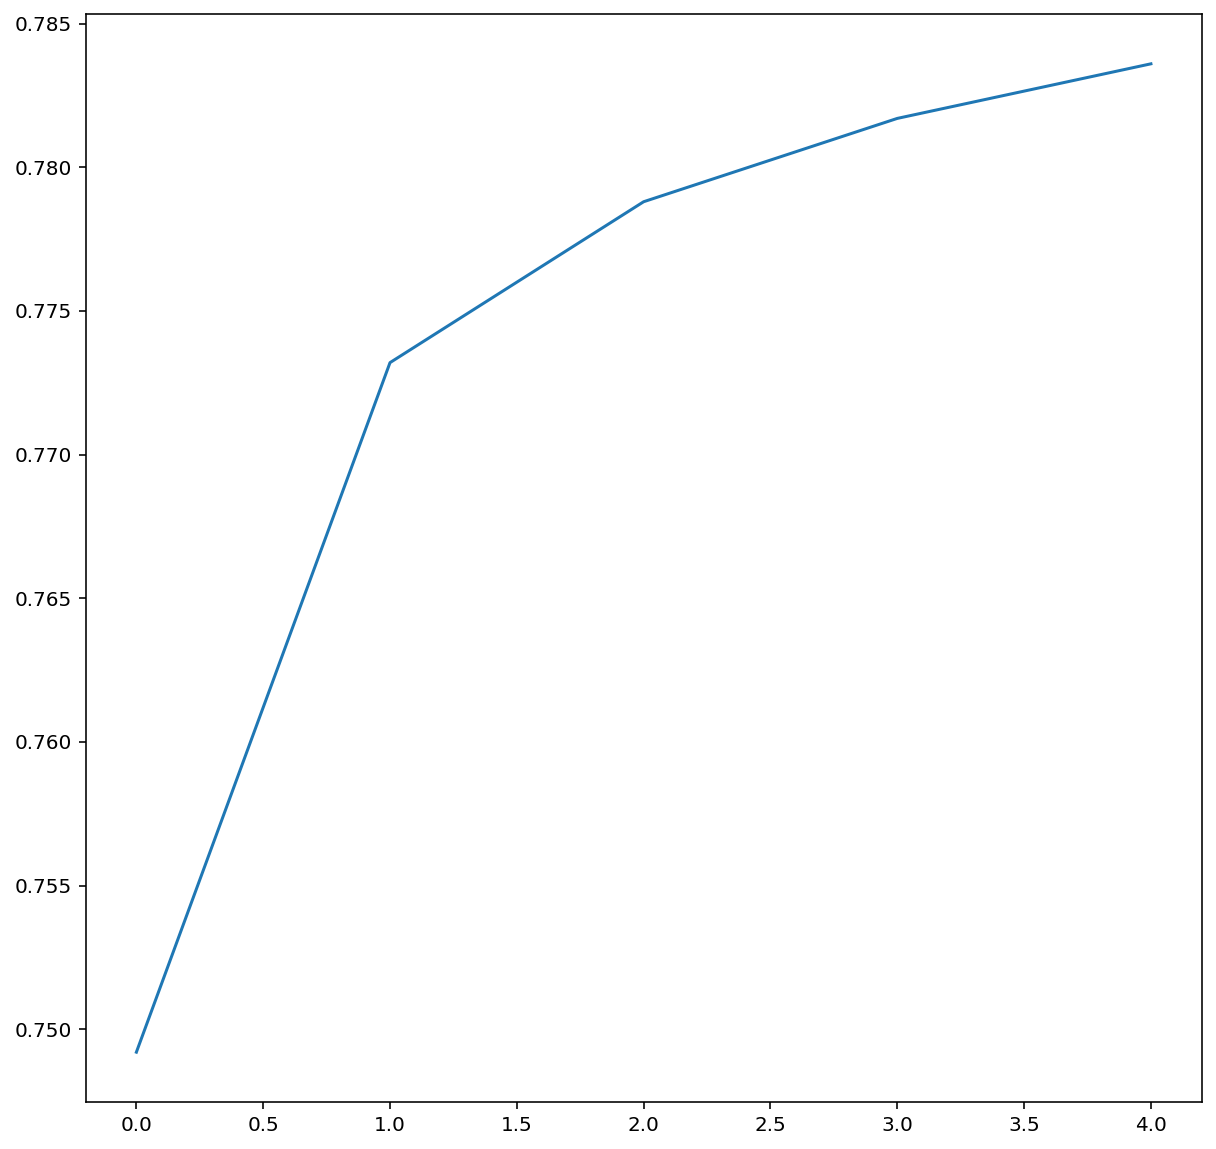

In [54]:
plt.plot([d['test_acc'] for d in results])

Ioffe Trick:  
https://stackoverflow.com/questions/36456436/how-can-i-define-only-the-gradient-for-a-tensorflow-subgraph/36480182#36480182  
https://stackoverflow.com/questions/49757285/tensorflow-use-different-expression-for-forward-and-backward-pass?rq=1

In [261]:
optimizer_args = {}
optimizer_args["optimizer"] = "sgdw"
optimizer_args["lr"] = .1 #* schedule(step)
optimizer_args["weight_decay"] = 5e-4 #* schedule(step)
optimizer_args["momentum"] = .9 
optimizer_args["nesterov"] = True

In [262]:
r_schedule = tf.keras.optimizers.schedules.ExponentialDecay(.1, decay_steps=4000, decay_rate=0.95, staircase=True)
mt = ModelTrainer(conv2_mask, ds_train = ds_train_cif10, ds_test = ds_test_cif10, optimizer_args=optimizer_args)

In [534]:
tf.equal(conv2_mask.layers[0].mask[0], initial_weights_mask[0][0][0]).numpy().all()

True

In [237]:
64*16*16

16384

- check the distribution of positive and negative weight values  
- check the distribution of positive and negative gradients (but here, gradients regarding the weights !!)  

**Fix sign_update! Multiplying weights with the sign of gradients doesn't work because negative weight values will get positive if gradient is negative (but should stay negative)**
- positive w, positive grad --> w (**stay**)
- positive w, negative grad --> -w (**flip**)
- negative w, positive grad --> w (**flip**)
- negative w, negative grad --> -w (**stay**)
- pos/neg w, zero grad --> +/- w (**stay**)

In [109]:
old_weights = mt.model.layers[-1].w.numpy()

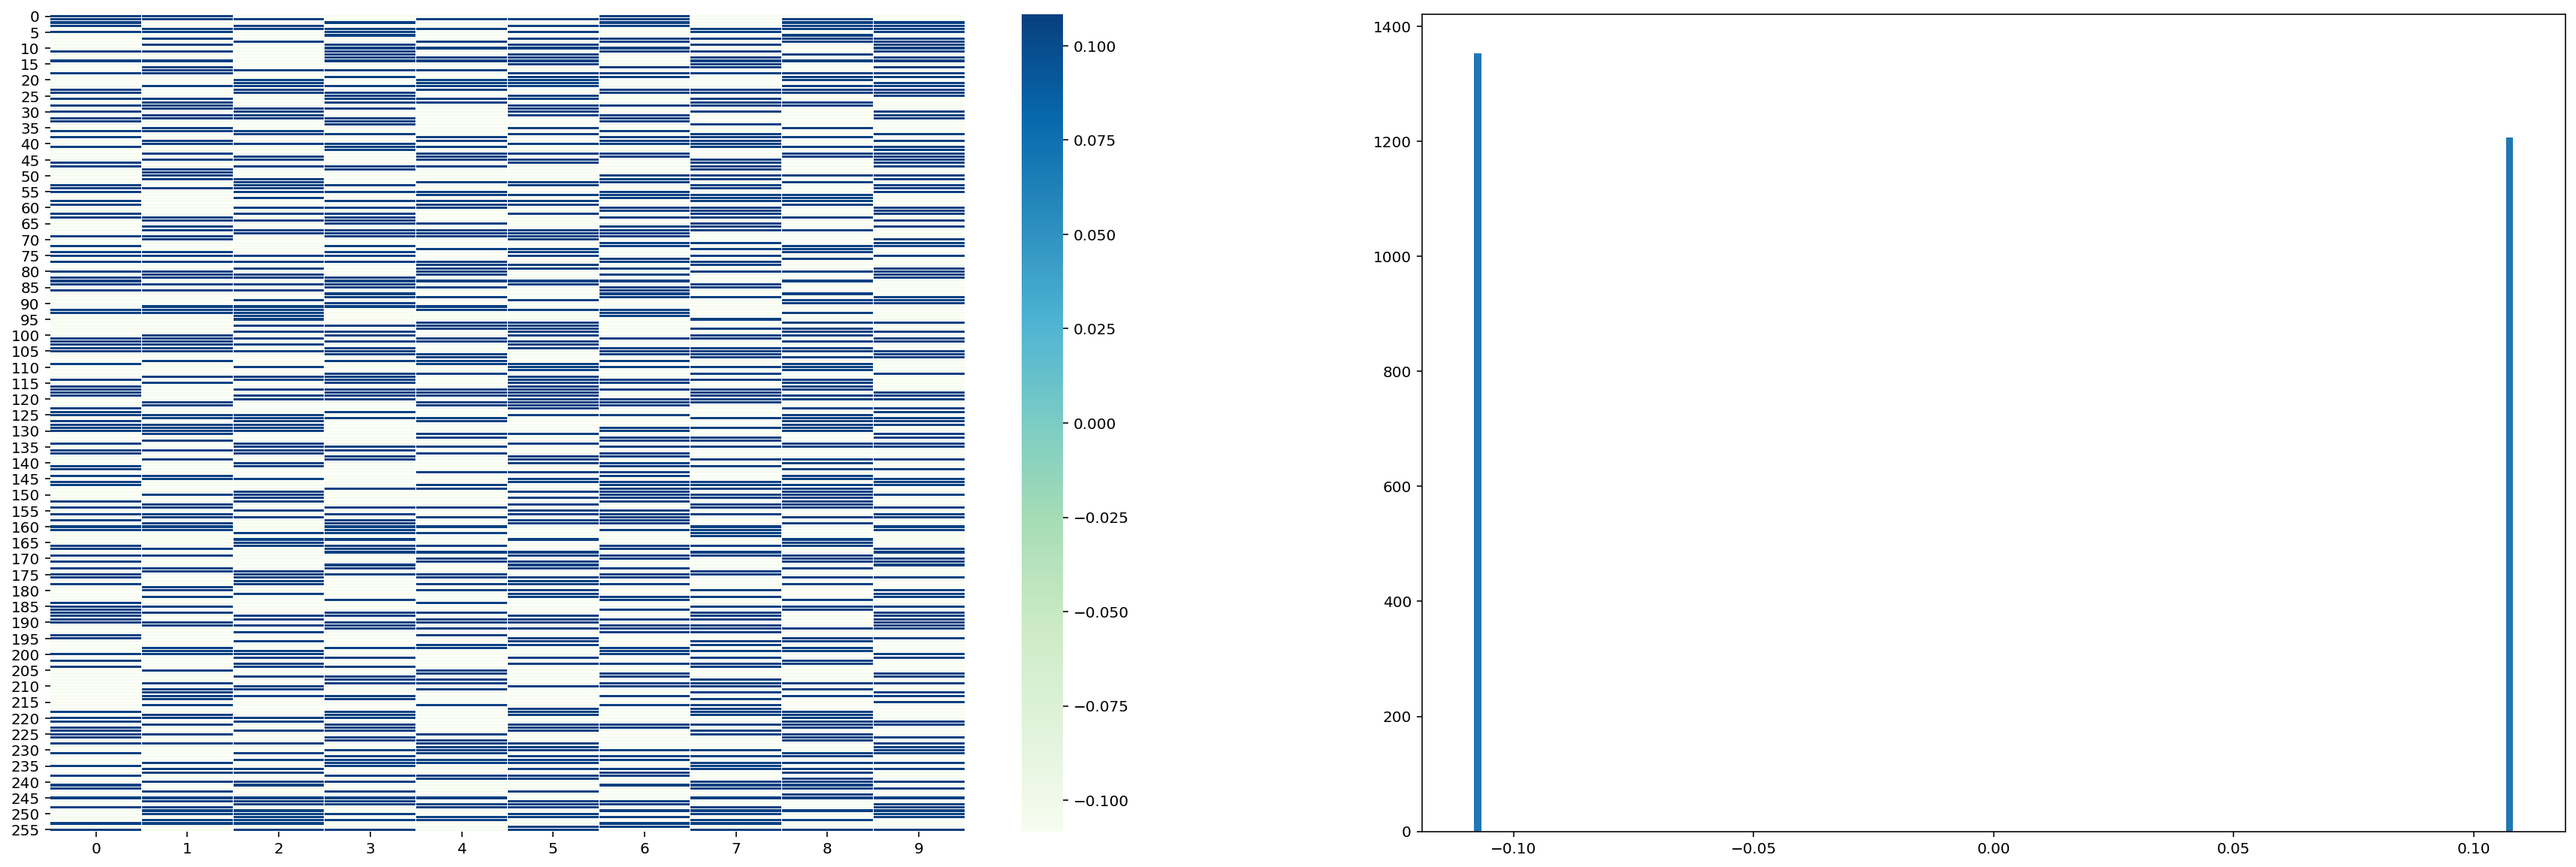

In [110]:
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
sns.heatmap(old_weights, cmap="GnBu", linewidth=.1)
plt.subplot(1,2,2)
_ = plt.hist(old_weights.flatten(), bins=140)

In [111]:
mt.sign_initializer()

[0.09931586, 0.44546863, 2.5336986, 0.36564934, 0.38827083]
[0.15476362, 0.5235691, 3.1329184, 0.3833968, 0.34033814]
[0.116690405, 0.47212315, 2.5524838, 0.32013917, 0.29725233]
[0.10708868, 0.42218903, 2.3821719, 0.31045896, 0.3166226]
[0.12965442, 0.5110131, 2.714793, 0.36025792, 0.35418683]
[0.11938559, 0.41902778, 2.5239596, 0.33239338, 0.29445767]
[0.101536945, 0.41204223, 2.2206798, 0.30131593, 0.2930364]
[0.090064056, 0.34978455, 2.0429819, 0.25428587, 0.24278188]
[0.08718996, 0.28735933, 1.615968, 0.18184866, 0.17527023]
[0.13424996, 0.5340972, 2.9702613, 0.40186924, 0.39675996]
[0.09410548, 0.32460627, 2.0199506, 0.24686009, 0.24016401]
[0.1253036, 0.4595339, 2.2989357, 0.3041818, 0.3026099]
[0.09677063, 0.32961798, 1.9371774, 0.24580866, 0.24353677]
[0.13410932, 0.5394232, 2.8160548, 0.36481112, 0.37025774]
[0.09230474, 0.40737498, 2.1975815, 0.26958448, 0.23859663]
[0.12924562, 0.46055502, 2.5366926, 0.3134851, 0.312405]
[0.08353011, 0.2853827, 1.6113713, 0.20170859, 0.1861

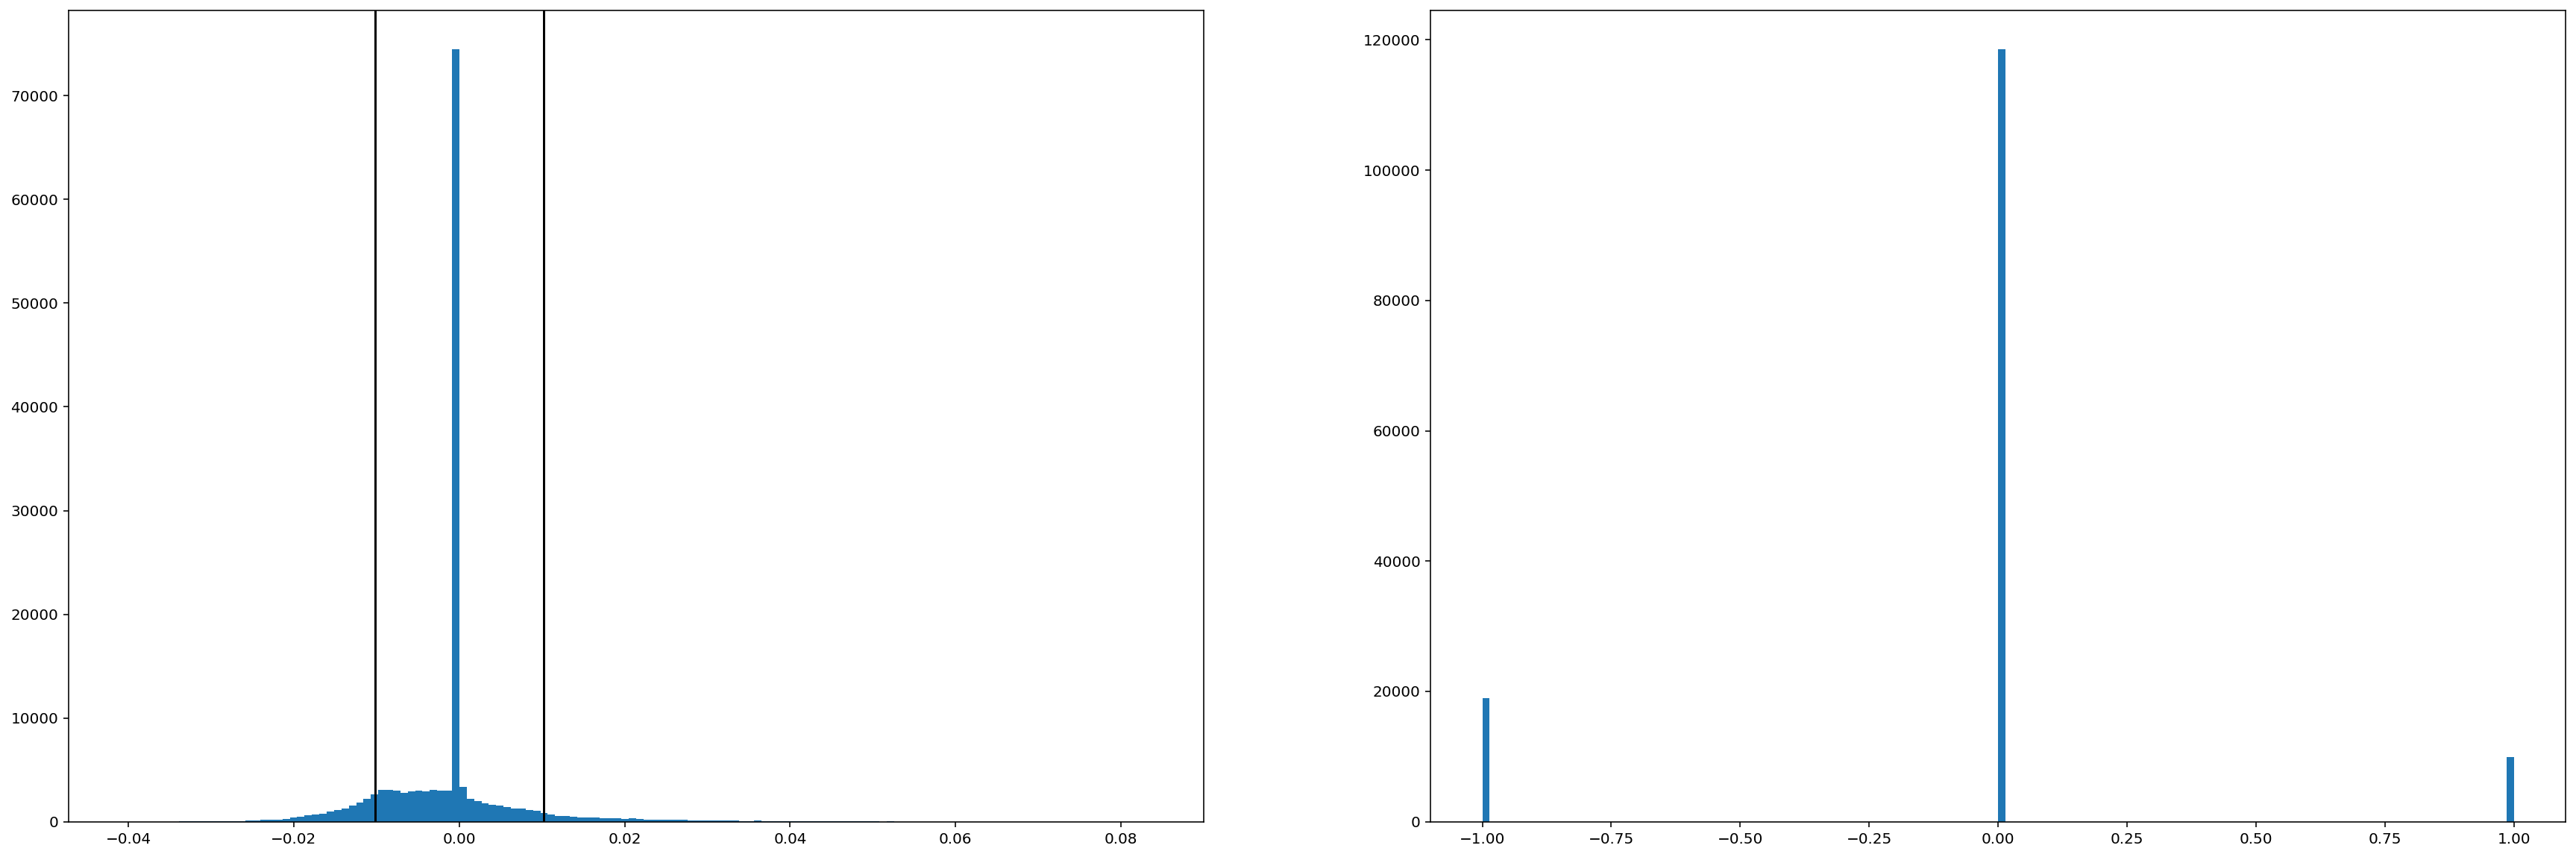

In [90]:
layer=4
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
_ = plt.hist(model.layers[layer].mask.numpy().flatten(), bins=140)
plt.axvline(model.layers[layer].tanh_th, c="black")
plt.axvline(-model.layers[layer].tanh_th, c="black")
plt.subplot(1,2,2)
_ = plt.hist(model.layers[layer].bernoulli_mask.numpy().flatten(), bins=140)

In [502]:
np.unique(mt.model.layers[-3].bernoulli_mask.numpy(), return_counts=True)

(array([-1.,  0.,  1.], dtype=float32), array([  35636, 2026181,   35335]))

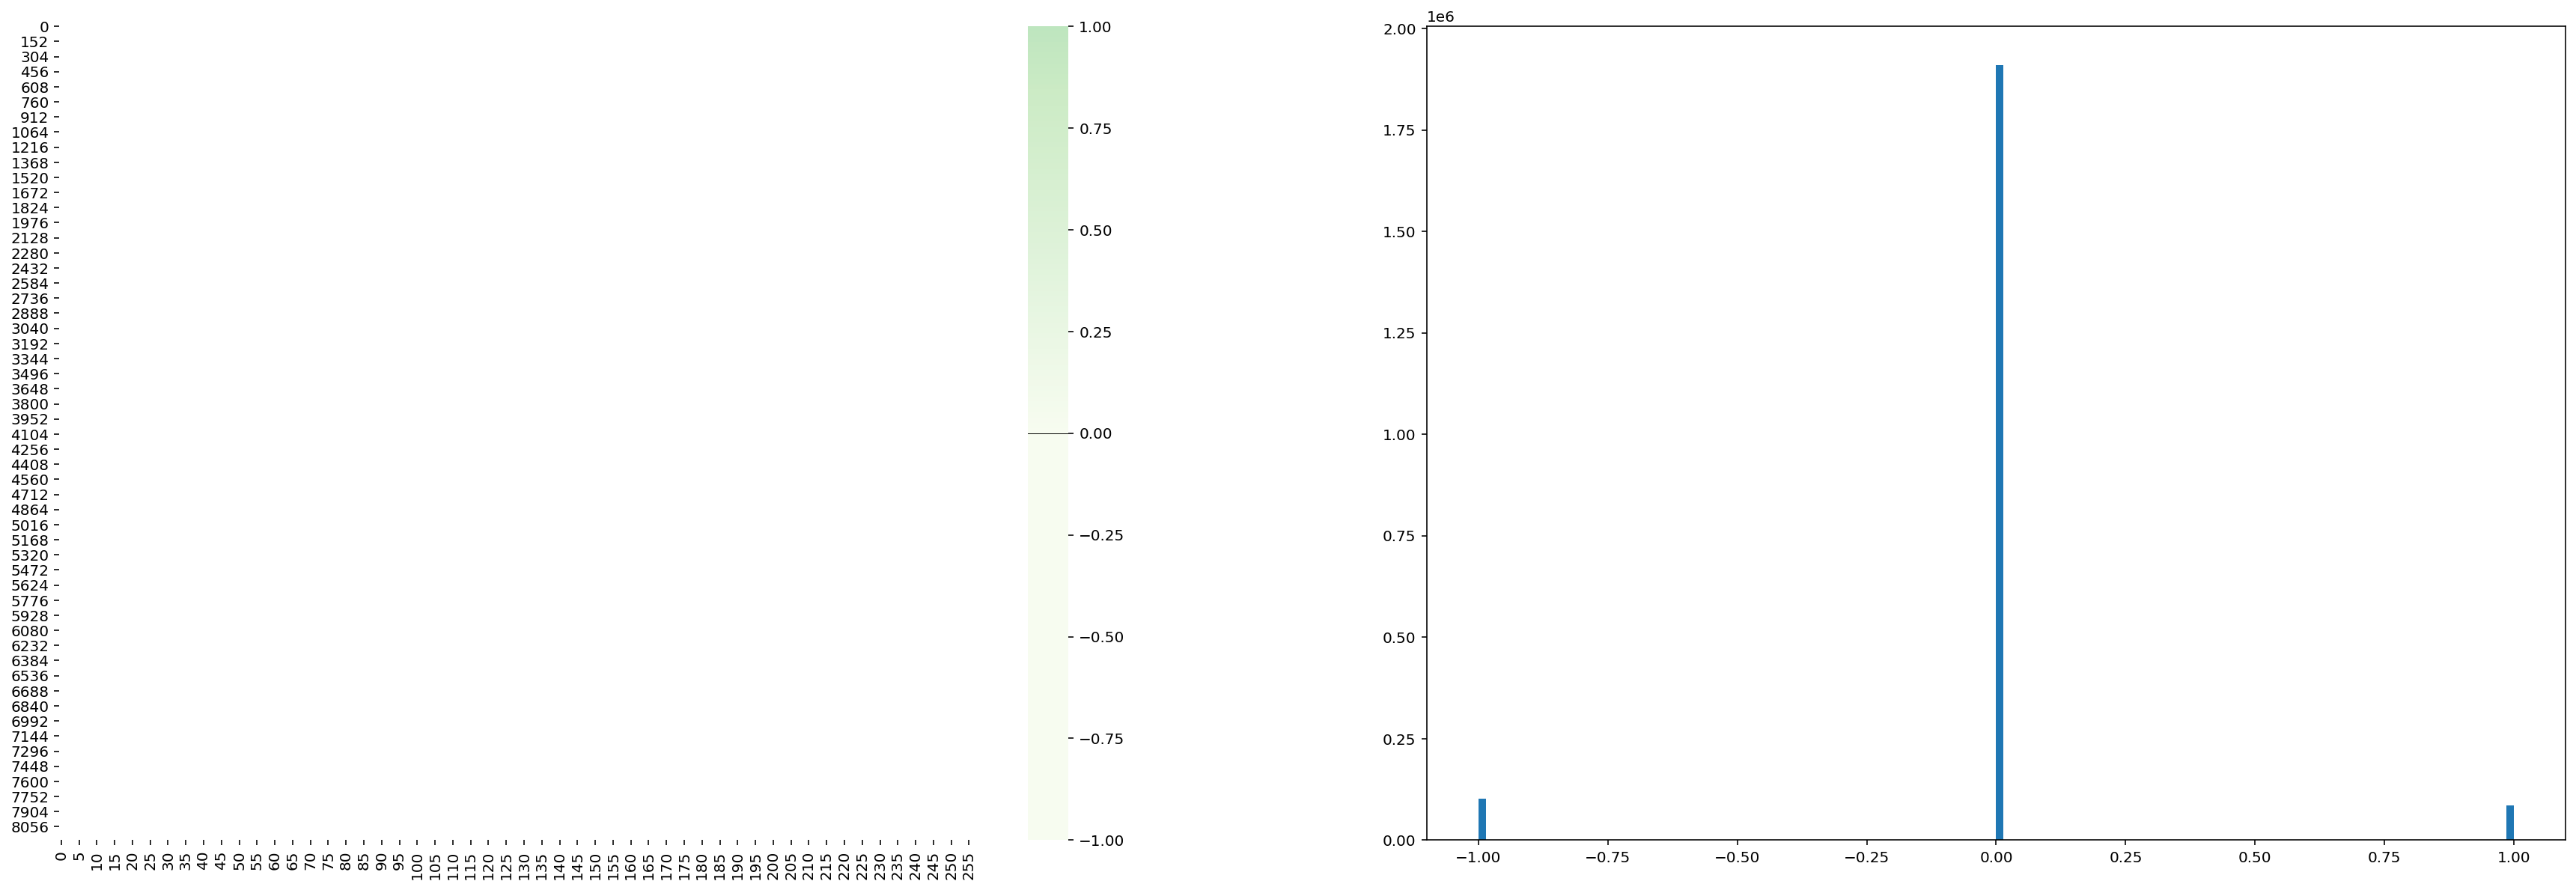

In [81]:
layer = -3
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
sns.heatmap(model.layers[layer].bernoulli_mask.numpy(), cmap=cmap, linewidth=.1)
plt.subplot(1,2,2)
_ = plt.hist(model.layers[layer].bernoulli_mask.numpy().flatten(), bins=140)

**Should the number of 1s and -1s be the same? How could they be chosen by the net? Maybe re-try seperate thresholds for positive and negative values**

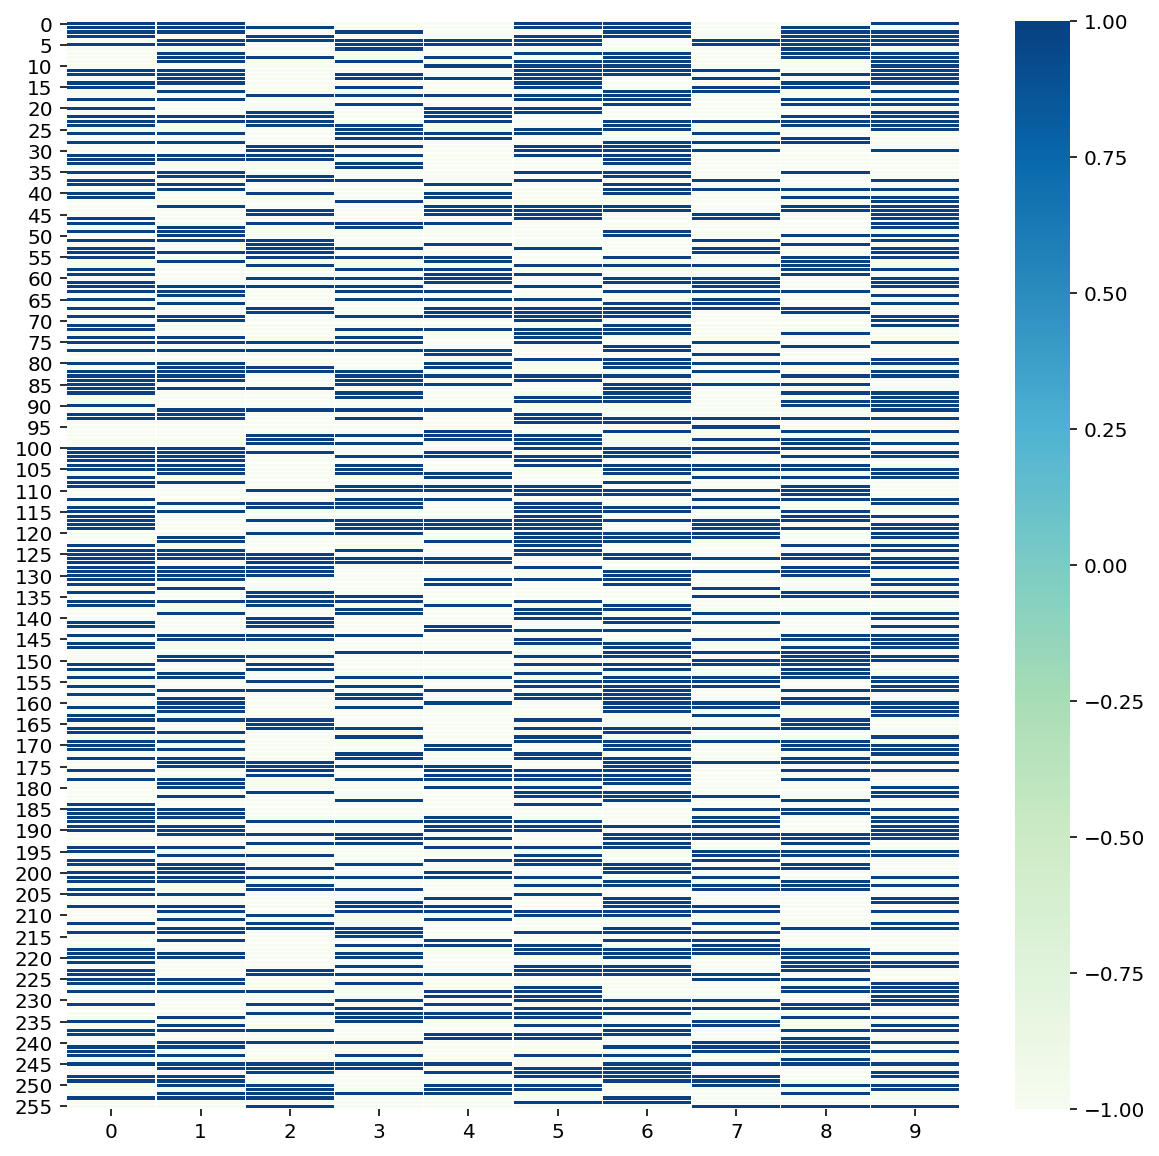

In [113]:
sns.heatmap(tf.where(tf.equal(old_weights, mt.model.layers[-1].w.numpy()), 1, -1), cmap="GnBu", linewidth=.1)

In [575]:
np.isnan(mt.model.layers[-1].tanh_mask()).any()

False

In [576]:
np.unique(mt.model.layers[-1].tanh_mask())

array([-1.        , -0.99999994,  0.        ,  0.99999994,  1.        ],
      dtype=float32)

[To Masked Model](#masked_model)

In [263]:
mt.train(epochs=50, allen=False, sign_initializer=False)

14.21% of weights are 'remaining' --- total weights: 2425024, total weights left: 344623.0
End of Epoch 1. Accuracy = 0.101240 --- Mean Loss = 2152999168.000000
96.12% of weights are 'remaining' --- total weights: 2425024, total weights left: 2330815.0
Evaluation Loss:  14.503415  Accuracy:  0.0999
End of Epoch 6. Accuracy = 0.111760 --- Mean Loss = 1758012.875000
98.22% of weights are 'remaining' --- total weights: 2425024, total weights left: 2381898.0
Evaluation Loss:  14.235631  Accuracy:  0.1174
End of Epoch 11. Accuracy = 0.099800 --- Mean Loss = 46365320.000000
97.13% of weights are 'remaining' --- total weights: 2425024, total weights left: 2355361.0
Evaluation Loss:  14.506602  Accuracy:  0.1004
End of Epoch 16. Accuracy = 0.097840 --- Mean Loss = 13072152.000000
98.56% of weights are 'remaining' --- total weights: 2425024, total weights left: 2390200.0
Evaluation Loss:  14.522546  Accuracy:  0.1001


KeyboardInterrupt: 

In [93]:
tf.size(mt.model.layers[-1].bernoulli_mask).numpy() / tf.reduce_sum(tf.math.abs(mt.model.layers[-1].bernoulli_mask)).numpy()

1.0

In [245]:
mt.train_visualize()

KeyboardInterrupt: 

<Figure size 720x720 with 0 Axes>

In [113]:
k = 500

In [109]:
t_topk = tf.math.top_k(t_resh, k, sorted=False).values

In [105]:
%timeit tf.reshape(t,[-1])

34.3 µs ± 281 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [120]:
%timeit tf.math.top_k(t_resh, k, sorted=True).values

78.6 ms ± 2.37 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [121]:
%timeit tf.math.top_k(t_resh, k, sorted=False).values

76.7 ms ± 1.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [220]:
%timeit tf.nn.top_k(t_resh, k, sorted=False).values

75 ms ± 240 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [116]:
%timeit tf.sort(t_resh, axis=-1, direction='DESCENDING')[:k]

77.8 ms ± 985 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [124]:
%timeit tf.math.reduce_min(t_topk)

18.8 µs ± 134 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [125]:
%timeit tf.reduce_min(t_topk)

18.5 µs ± 568 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [111]:
tf.math.reduce_min(t_topk)

<tf.Tensor: shape=(), dtype=float64, numpy=0.9998535581468141>

In [238]:
mask = conv2_mask.layers[0].mask
sigmoid_mask = tf.math.sigmoid(mask)
sigmoid_mask_flattened = tf.reshape(sigmoid_mask, [-1])

In [239]:
np.where(tf.math.is_nan(mask).numpy())

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

In [240]:
np.argwhere(tf.math.is_nan(mt.model.trainable_weights[0]).numpy())

array([], shape=(0, 4), dtype=int64)

In [241]:
sigmoid_mask[tf.math.is_nan(sigmoid_mask)]

<tf.Tensor: shape=(0,), dtype=float32, numpy=array([], dtype=float32)>

In [242]:
mask[tf.math.is_nan(mask)]

<tf.Tensor: shape=(0,), dtype=float32, numpy=array([], dtype=float32)>

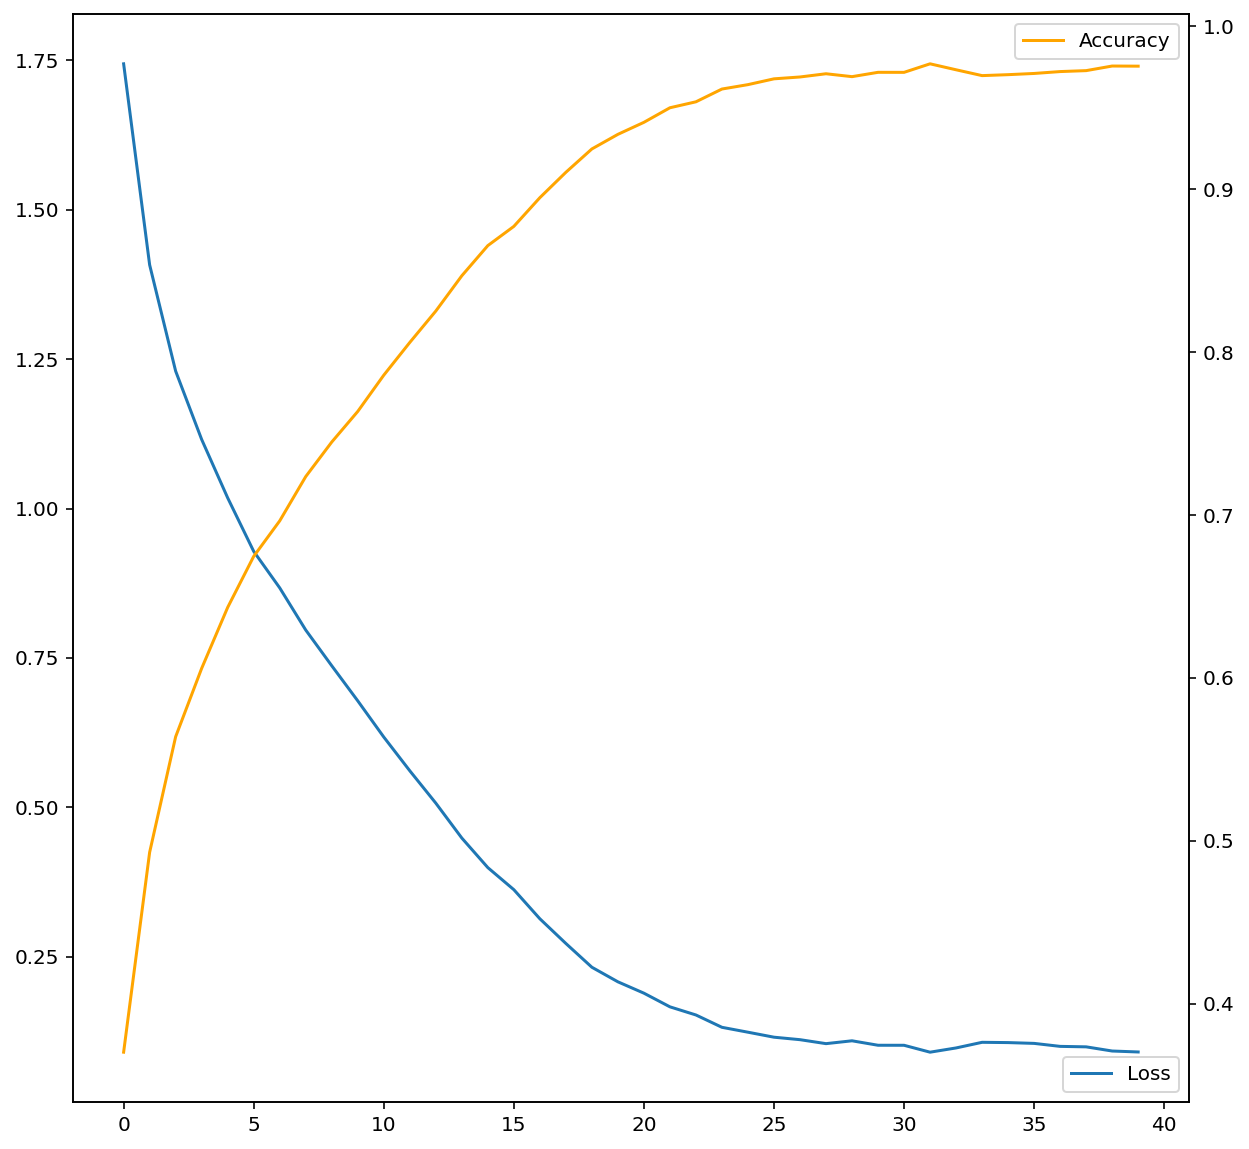

In [75]:
plt.plot(mt.loss_history, label="Loss")
plt.legend(loc=4)
plt.twinx()
plt.plot(mt.acc_history, c="orange", label="Accuracy")
plt.legend(loc=1)

In [76]:
mt.evaluate()

Evaluation Loss: 1.2822456359863281
Evaluation Accuracy: 0.680400013923645


In [77]:
global_no_ones = np.sum([np.sum(np.abs(layer.tanh_mask())) for layer in mt.model.layers if layer.type == "fefo" or layer.type == "conv"])
global_size = np.sum([tf.size(layer.bernoulli_mask) for layer in mt.model.layers if layer.type == "fefo" or layer.type == "conv"])

remaining_ones_ratio = (global_no_ones/global_size)*100
print(f"{remaining_ones_ratio:.2f}% of weights are 'remaining'")

9.91% of weights are 'remaining'


In [64]:
a = np.random.randn(300,100)

In [65]:
val, idx = tf.math.top_k(a.flatten(), k=int((300*100)*0.2))

In [77]:
tf.argsort(a)

<tf.Tensor: shape=(300, 100), dtype=int32, numpy=
array([[11, 24, 75, ..., 66, 19, 14],
       [24, 86, 38, ..., 40, 30, 89],
       [83, 36, 15, ..., 28, 96, 93],
       ...,
       [54, 76,  2, ..., 28, 87, 29],
       [76, 19, 59, ..., 43, 87, 83],
       [30, 74, 70, ..., 78, 52, 61]], dtype=int32)>

In [68]:
val

<tf.Tensor: shape=(6000,), dtype=float64, numpy=
array([3.91258559, 3.78415229, 3.75953425, ..., 0.85075063, 0.85074833,
       0.85066566])>

In [69]:
idx

<tf.Tensor: shape=(6000,), dtype=int32, numpy=array([17851, 15259,  9919, ..., 17635, 27352,  7246], dtype=int32)>

In [71]:
a.flatten()[idx]

array([3.91258559, 3.78415229, 3.75953425, ..., 0.85075063, 0.85074833,
       0.85066566])

# What causes overfitting?
- dynamic scaling
- sigmoid multiplier

In [145]:
mt.mask_history

[[<tf.Tensor: shape=(3, 3, 3, 64), dtype=float32, numpy=
  array([[[[0., 0., 0., ..., 1., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 1., 0., 0.]],
  
          [[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 1., 0., ..., 0., 0., 0.]],
  
          [[0., 0., 0., ..., 0., 0., 0.],
           [0., 1., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]]],
  
  
         [[[0., 1., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 1., 0., 0.]],
  
          [[0., 0., 0., ..., 0., 0., 0.],
           [0., 1., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]],
  
          [[0., 0., 0., ..., 0., 0., 0.],
           [0., 1., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]]],
  
  
         [[[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]],
  
          [[0., 1., 0., .

In [125]:
#@tf.function
def train_supermask_model(model, ds_train, epochs=6, prune_neurons=False, keep_input=True):
    
    lr1 = 1.
    #lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr1, decay_steps=100000, decay_rate=0.99, staircase=True)

    #optimizer = tf.keras.optimizers.SGD(learning_rate=lr1, momentum=0.9)
    
    #loss_fn = tf.keras.losses.CategoricalCrossentropy()
    loss_metric = tf.keras.metrics.Mean()
    acc_metric = tf.keras.metrics.CategoricalAccuracy()
    
    loss_history = []
    acc_history = []
    
    remaining_ones_ratio_history = []
    
    #with tf.device('/CPU:0'):
    layerwise_output_all = []
    gradient_history = []
    mask_history = []
    
    mt = ModelTrainer(model, lr=lr1)
    
    epoch_half = epochs // 2
    epoch_quarter = epoch_half // 2
    
    for epoch in range(epochs):
        
        #if epoch == epoch_half:
        #    mt.update_lr(lr1/2)
            #optimizer = tf.keras.optimizers.SGD(learning_rate=lr1/2, momentum=0.9)
        #elif epoch == (epoch_half+epoch_quarter):
        #    mt.update_lr(lr1/4)
            #optimizer = tf.keras.optimizers.SGD(learning_rate=lr1/4, momentum=0.9)
    
        #print(f"Start of epoch {epoch+1}")

        # Iterate over the batches of the dataset.
        for step, (x_batch_train,y_batch_train) in enumerate(ds_train):
#            with tf.GradientTape() as tape:
#                predicted, layerwise_output = model(x_batch_train, training=True) #, epoch
#                layerwise_output_all.append(layerwise_output)
                # Compute reconstruction loss
#                loss = loss_fn(y_batch_train, predicted)

 #           grads = tape.gradient(loss, model.trainable_weights)
            #print(grads)
            #print("gradient mean", tf.reduce_mean(grads))
            #gradient_history.append([tf.reduce_mean(g).numpy() for g in grads])
            #mask_weights = [var for var in model.trainable_weights if "kernel" not in var.name]
#            optimizer.apply_gradients(zip(grads, model.trainable_weights))
            loss, predicted = mt.train_step(x_batch_train, y_batch_train)

            loss_metric(loss)

            acc_metric(y_batch_train,predicted)
        
        #gc.collect()
        
        #with tf.device('/CPU:0'):
        #print(model.layers[0].mask)
        model
        
        mask_history.append([layer.bernoulli_mask for layer in model.layers if layer.type is "conv" or layer.type is "fefo"])
        loss_history.append(loss_metric.result().numpy())
        acc_history.append(acc_metric.result().numpy())
        
        #save the last gradient of each epoch
        #gradient_history.append(grads)
            
        print(f"End of Epoch: {epoch+1}: Accuracy = {acc_metric.result().numpy():.6f} --- Mean Loss = {loss_metric.result().numpy():.6f}")
        
        
        
        #if epoch % 20 == 0:
        #    global_no_ones = np.sum([np.sum(layer.bernoulli_mask) for layer in model.layers if layer.type == "fefo" or layer.type == "conv"])
        #    global_size = np.sum([tf.size(layer.bernoulli_mask) for layer in model.layers if layer.type == "fefo" or layer.type == "conv"])

        #    remaining_ones_ratio = (global_no_ones/global_size)*100
        #    print(f"{remaining_ones_ratio:.2f}% of weights are 'remaining'")
            #remaining_ones_ratio_history.append(remaining_ones_ratio)

    return model, loss_history, acc_history, mask_history #, layerwise_output_all, gradient_history, remaining_ones_ratio_history, mask_history

https://github.com/tensorflow/tensorflow/issues/32707  
https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

In [77]:
len(conv2_mask.trainable_weights)

5

In [78]:
for w in conv2_mask.trainable_weights:
    print(w.name, w.shape)

mask:0 (3, 3, 3, 64)
mask:0 (3, 3, 64, 64)
mask:0 (2688, 256)
mask:0 (256, 256)
mask:0 (256, 10)


In [79]:
for w in conv2_mask.non_trainable_weights:
    print(w.name, w.shape)

bias:0 (64,)
weights:0 (3, 3, 3, 64)
bias:0 (64,)
weights:0 (3, 3, 64, 64)
b:0 (256,)
w:0 (2688, 256)
b:0 (256,)
w:0 (256, 256)
b:0 (10,)
w:0 (256, 10)


In [129]:
conv2_mask, loss_history_mask, acc_history_mask, mask_history = train_supermask_model(conv2_mask, ds_train_cif10, epochs=10) #, layerwise_output_all, gradient_history, ones_ratio_history, mask_history

End of Epoch: 1: Accuracy = 0.112920 --- Mean Loss = 2.302460
End of Epoch: 2: Accuracy = 0.114810 --- Mean Loss = 2.302450
End of Epoch: 3: Accuracy = 0.115960 --- Mean Loss = 2.302440
End of Epoch: 4: Accuracy = 0.116010 --- Mean Loss = 2.302427
End of Epoch: 5: Accuracy = 0.117112 --- Mean Loss = 2.302414
End of Epoch: 6: Accuracy = 0.118460 --- Mean Loss = 2.302399
End of Epoch: 7: Accuracy = 0.119283 --- Mean Loss = 2.302383
End of Epoch: 8: Accuracy = 0.120158 --- Mean Loss = 2.302365
End of Epoch: 9: Accuracy = 0.120864 --- Mean Loss = 2.302346
End of Epoch: 10: Accuracy = 0.121472 --- Mean Loss = 2.302332


In [131]:
conv2_mask

In [163]:
mt.model.layers[0].bernoulli_mask

<tf.Tensor: shape=(3, 3, 3, 64), dtype=float32, numpy=
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 1., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 1.],
         [0., 1., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 1.],
         [0., 1., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 1., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 1., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
       

In [94]:
for layer in conv2_mask.layers:
    print(layer.type)
    if layer.type == "conv" or layer.type == "fefo":
        print(layer.bernoulli_mask)

conv
tf.Tensor(
[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 1. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 1. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 1. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]], shape=(3, 3, 3, 64), dtype=float32)
conv
tf.Tensor(
[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 1. 1. 1.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0

In [52]:
global_no_ones = np.sum([np.sum(layer.bernoulli_mask) for layer in mt.model.layers if layer.type == "fefo" or layer.type == "conv"])
global_size = np.sum([tf.size(layer.bernoulli_mask) for layer in mt.model.layers if layer.type == "fefo" or layer.type == "conv"])

remaining_ones_ratio = (global_no_ones/global_size)*100
print(f"{remaining_ones_ratio:.2f}% of weights are 'remaining'")

36.54% of weights are 'remaining'


In [156]:
just_eval(mt.model, ds_test_cif10)

Evaluation Loss: 1.42228102684021
Evaluation Accuracy: 0.5472999811172485


In [213]:
import seaborn as sns

In [222]:
tf.nn.bias_add(tf.Variable([[3,2],[0,2]]), tf.constant([1,1]))

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[4, 3],
       [1, 3]], dtype=int32)>

In [230]:
x = tf.Variable(np.random.randint(0,5,size=(10,1)))
x

<tf.Variable 'Variable:0' shape=(10, 1) dtype=int64, numpy=
array([[1],
       [3],
       [2],
       [0],
       [0],
       [3],
       [4],
       [0],
       [3],
       [2]])>

In [246]:
o = tf.Variable(1, dtype="int64")
o

<tf.Variable 'Variable:0' shape=() dtype=int64, numpy=1>

In [249]:
tf.concat([x,o], axis=-1)

InvalidArgumentError: ConcatOp : Ranks of all input tensors should match: shape[0] = [10,1] vs. shape[1] = [] [Op:ConcatV2] name: concat

In [231]:
w = tf.Variable(np.random.randint(0,5, size=(10,2)))
w

<tf.Variable 'Variable:0' shape=(10, 2) dtype=int64, numpy=
array([[4, 1],
       [2, 3],
       [3, 0],
       [0, 3],
       [2, 2],
       [4, 0],
       [1, 4],
       [1, 3],
       [1, 2],
       [2, 3]])>

In [234]:
tf.matmul(x,w, transpose_a=True)

<tf.Tensor: shape=(1, 2), dtype=int64, numpy=array([[39, 38]])>

In [216]:
mt.model.layers[4].shape

(2688, 256)

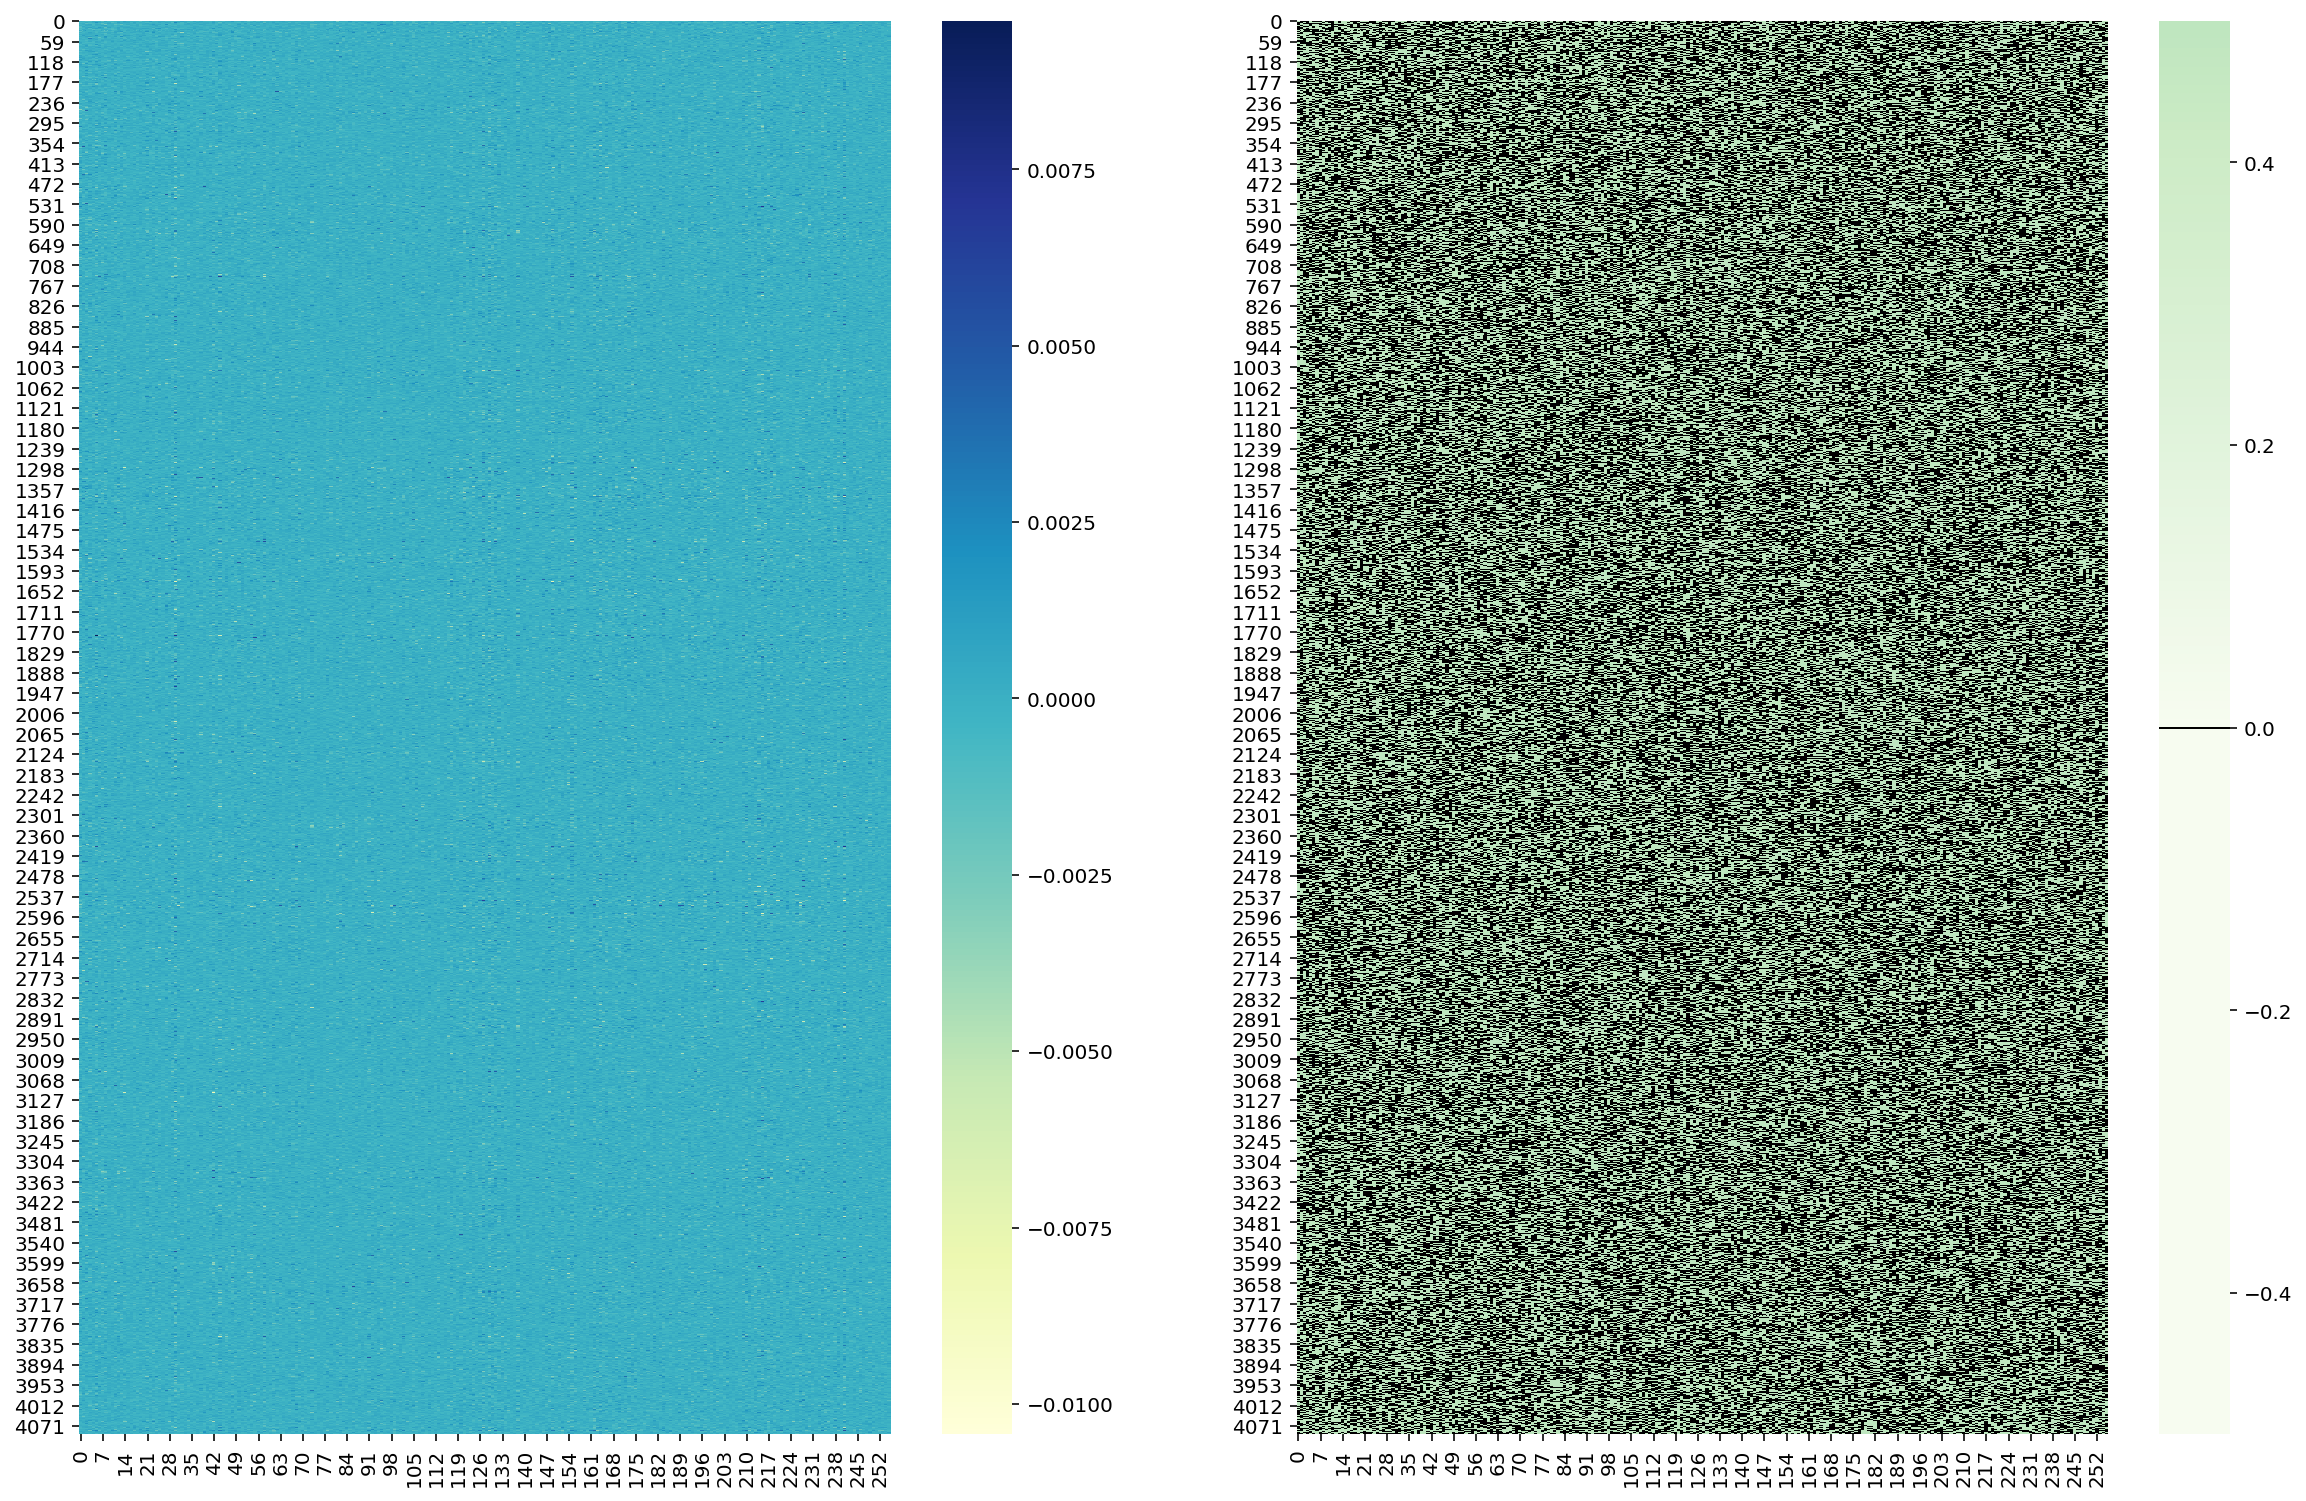

In [358]:
layer = -3
plt.figure(figsize=(20,13))
plt.subplot(1,2,1)
sns.heatmap(mt.model.layers[layer].mask.numpy(),cbar=True, cmap="YlGnBu")
plt.subplot(1,2,2)
sns.heatmap(mt.model.layers[layer].bernoulli_mask.numpy(),cmap=cmap, vmin=-0.5, vmax=0.5)

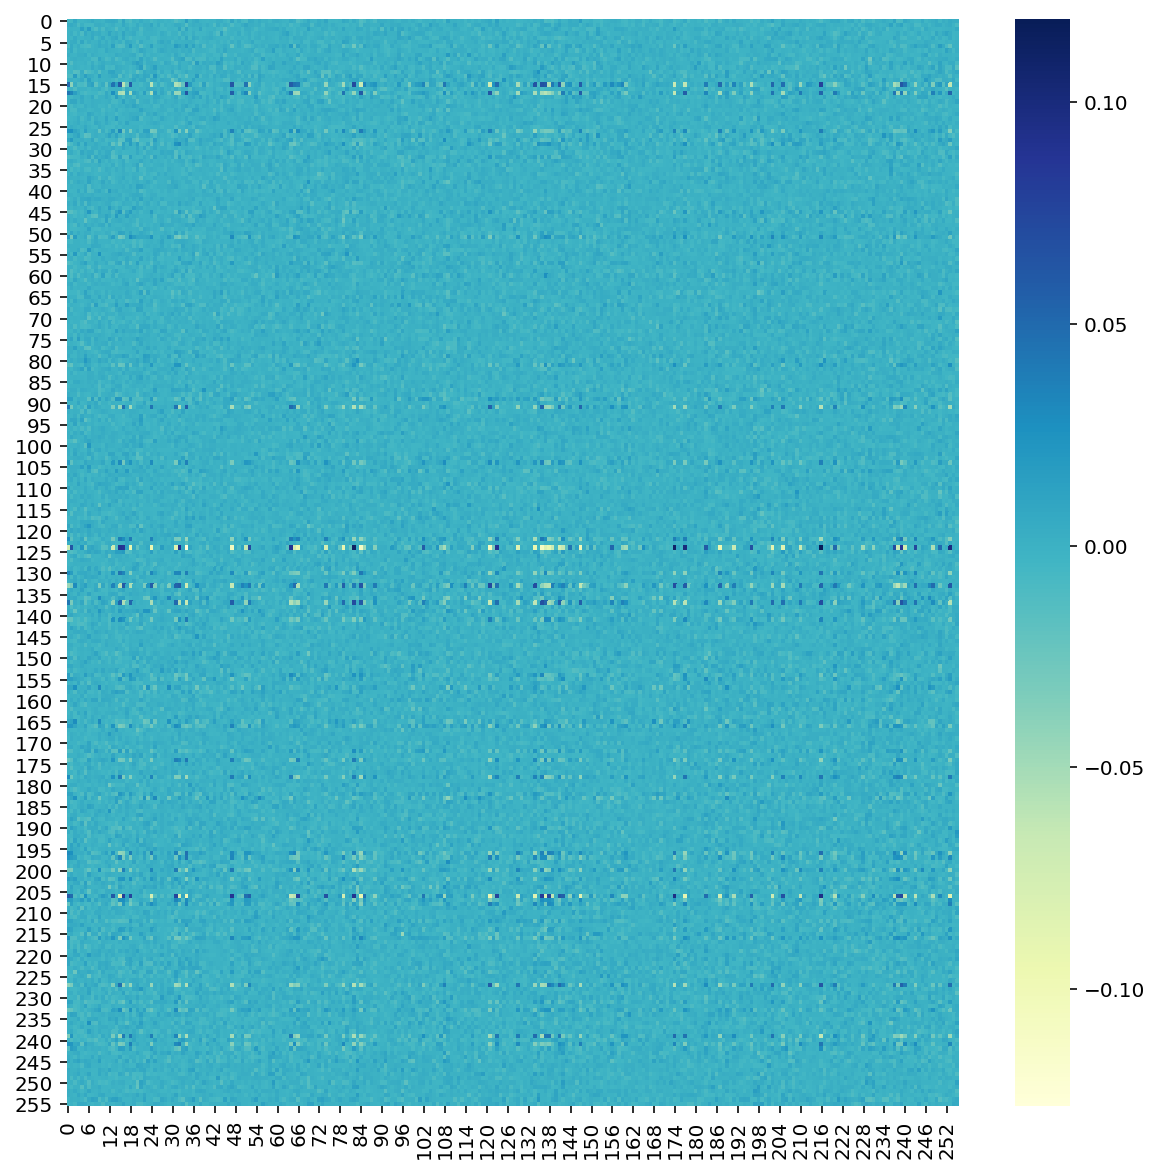

In [158]:
sns.heatmap(conv2_mask.layers[5].mask.numpy(),cbar=True, cmap="YlGnBu")

In [52]:
INPUT_SHAPE[0:]

(128, 32, 32, 3)

In [362]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=INPUT_SHAPE[1:], batch_size=256))
model.add(conv2_mask.layers[0])
#model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

In [363]:
test_img = iter(ds_train_cif10).next()[0][0]

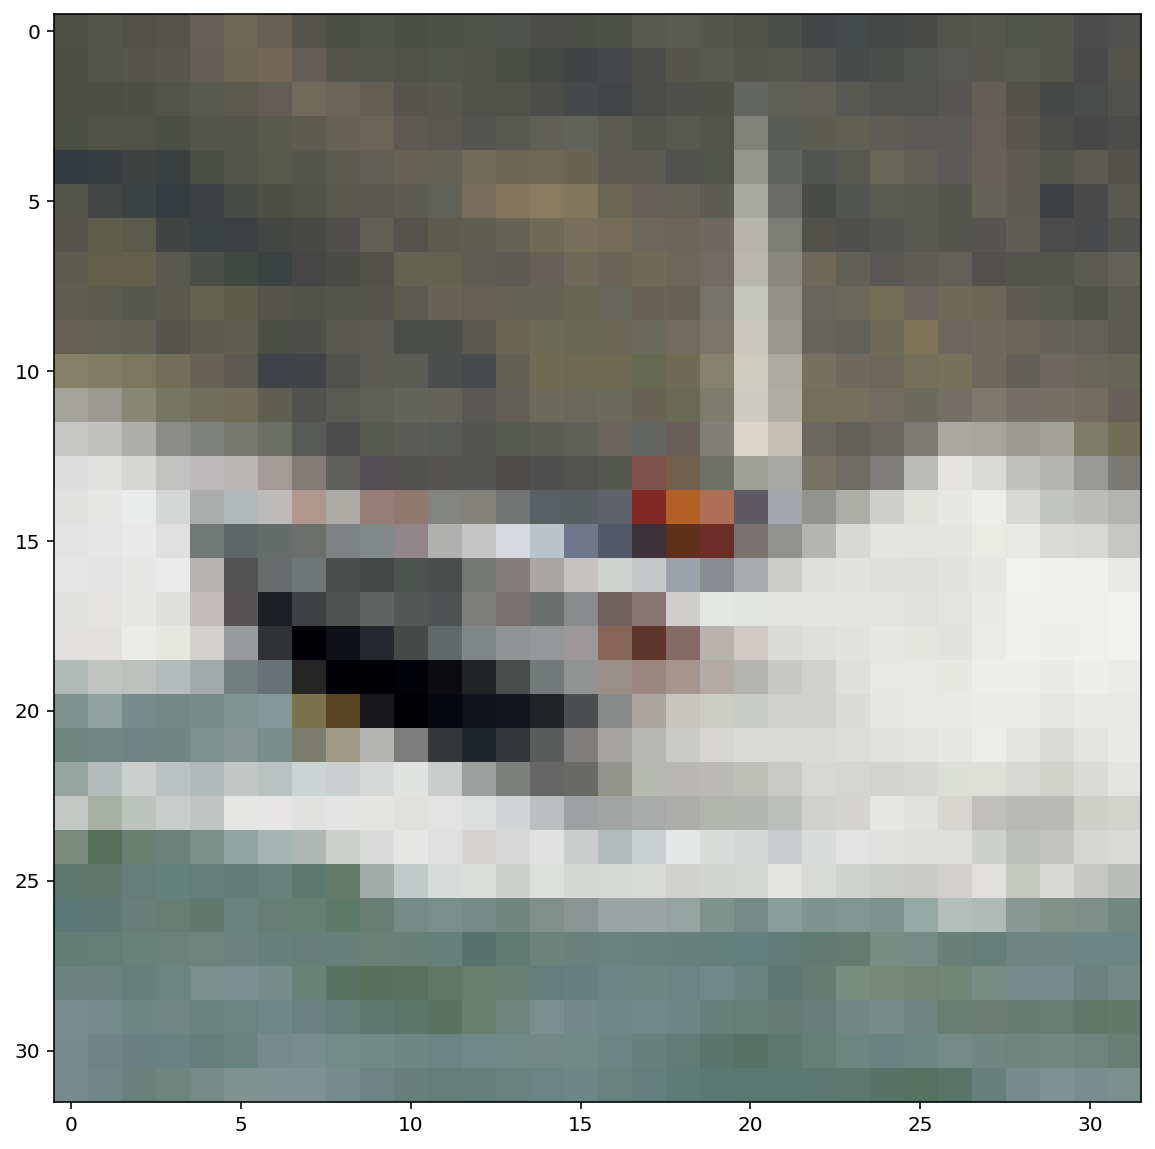

In [364]:
plt.imshow(test_img)

In [365]:
test = model(tf.expand_dims(test_img, axis=0))

In [366]:
test0 = test[0].numpy()

In [367]:
test0.shape

(32, 32, 64)

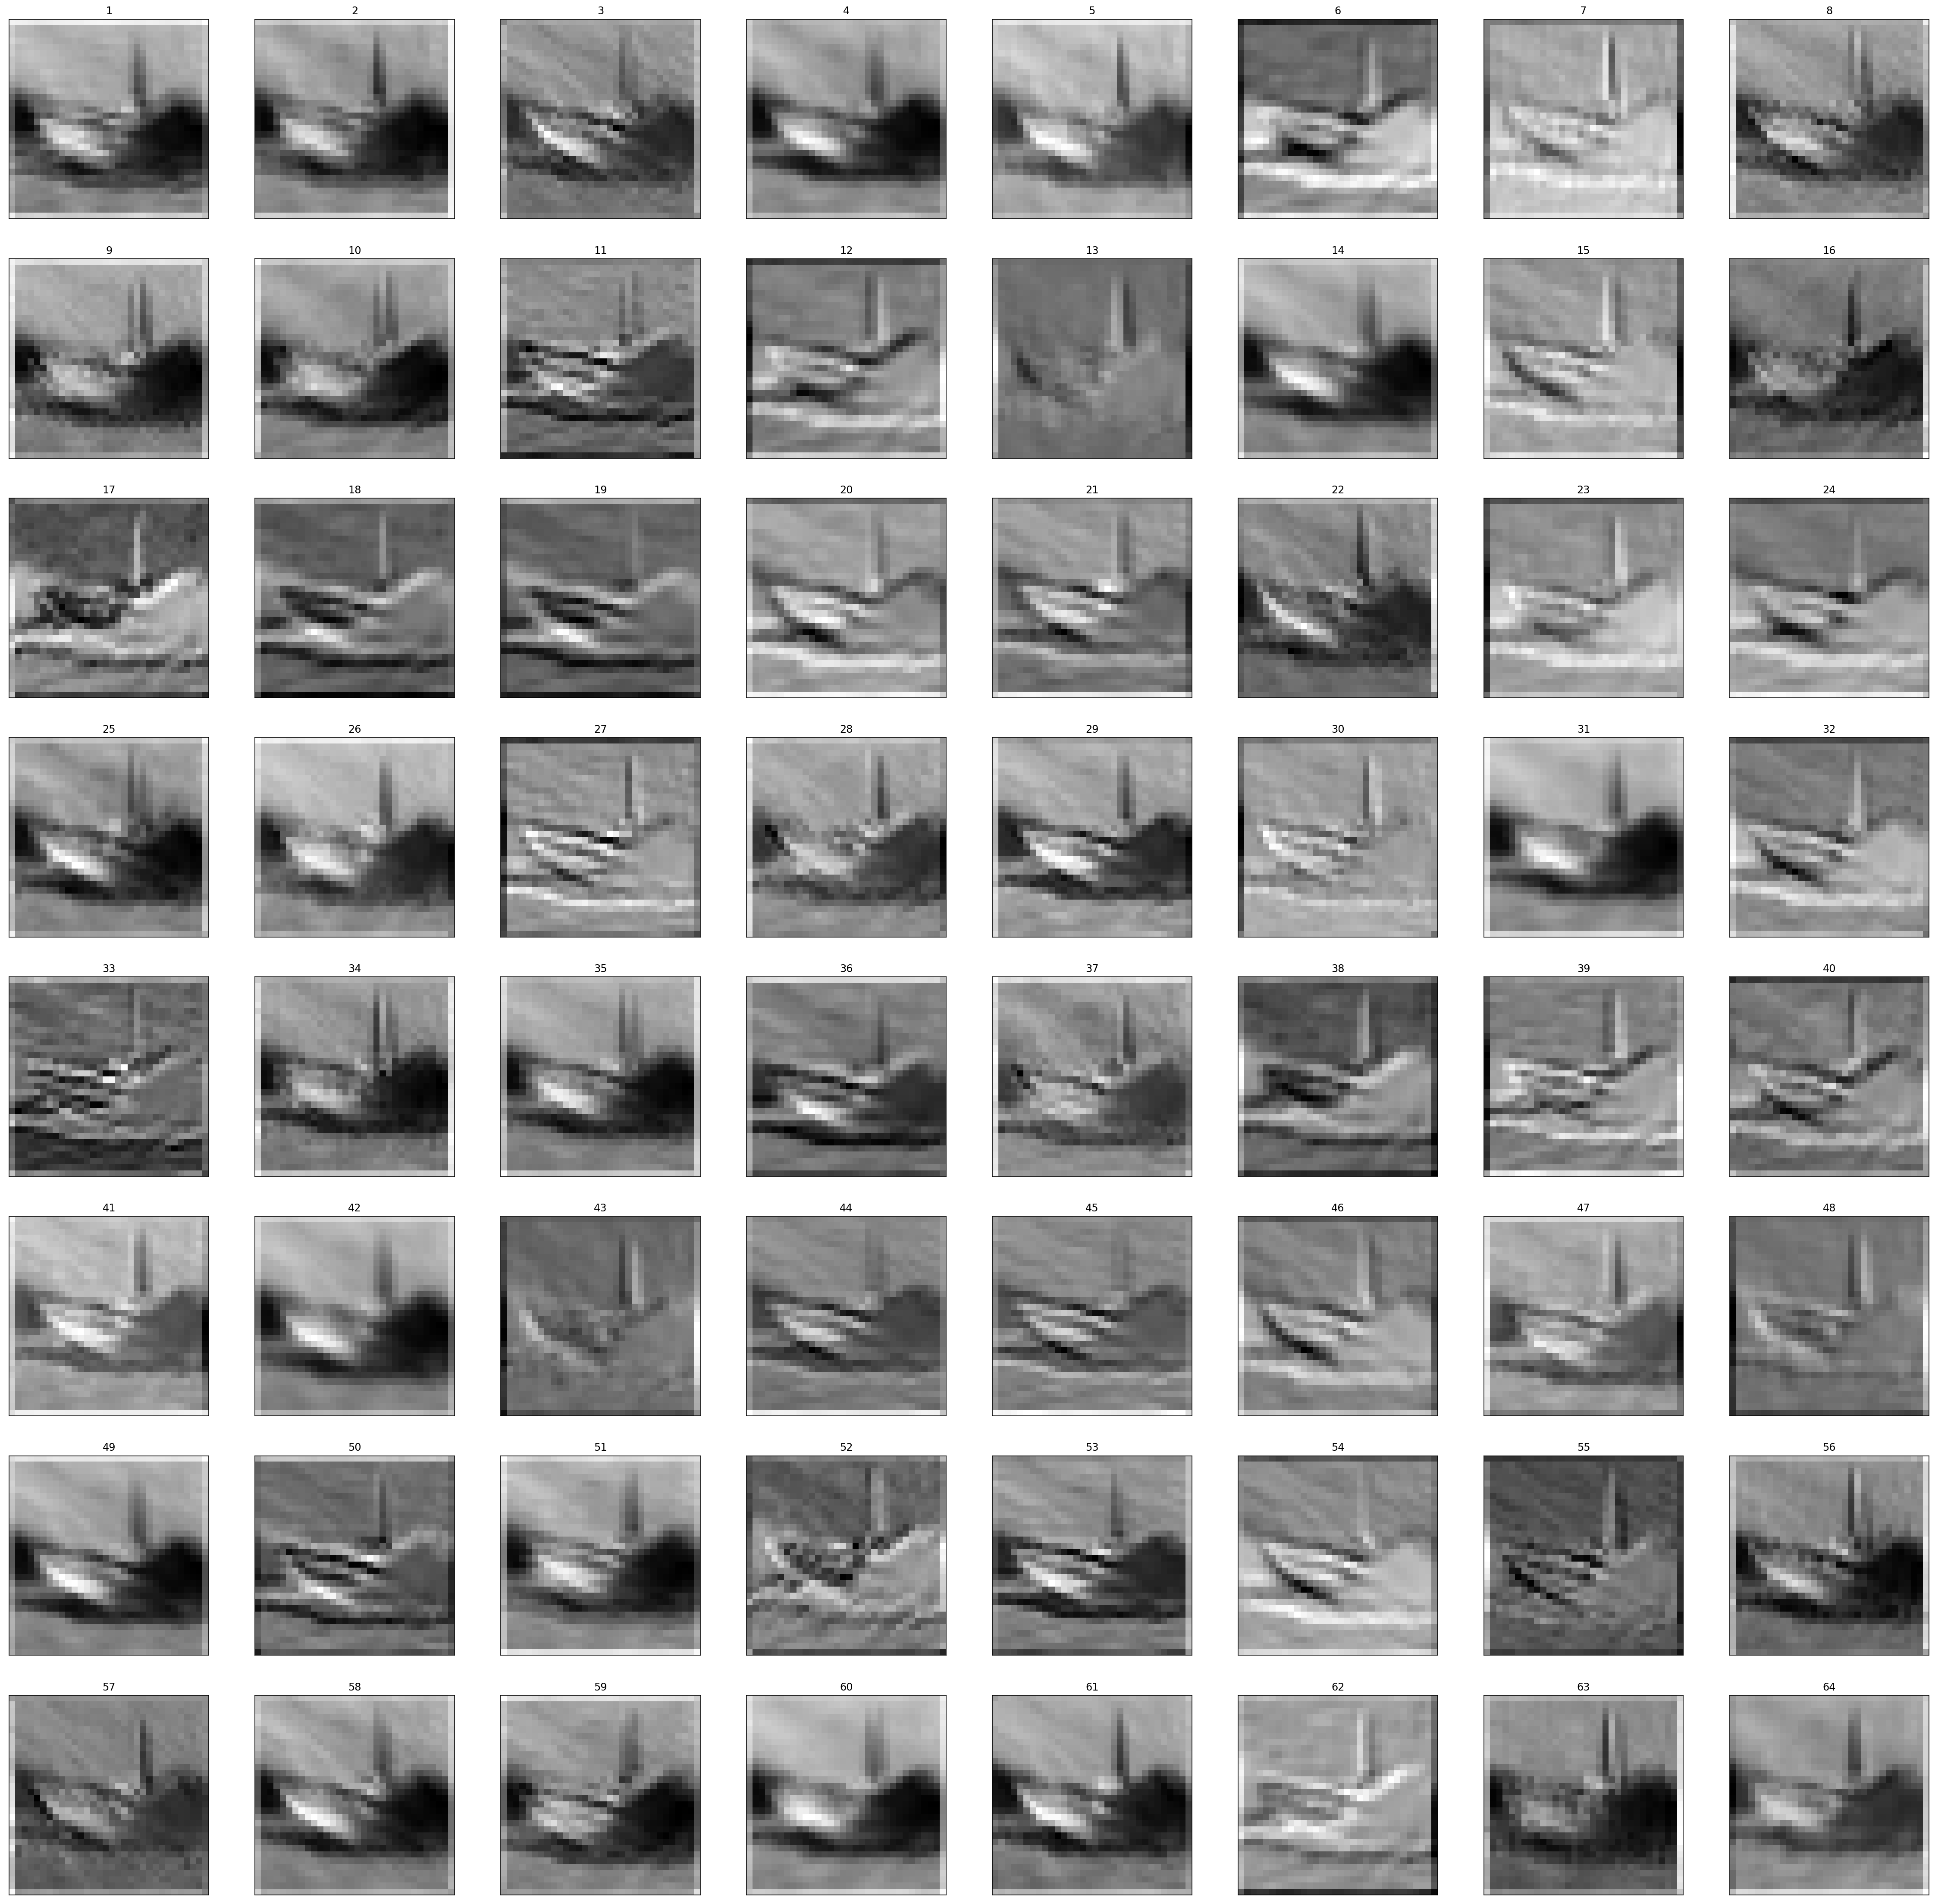

In [368]:
square = 8
ix = 1
plt.figure(figsize=(40,40))
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.title(ix)
        # plot filter channel in grayscale
        plt.imshow(test0[:, :, ix-1], cmap='gray')
        ix += 1

In [55]:
a = 0
b = 1

mask_history[0,0,a,:,:,10]

TypeError: list indices must be integers or slices, not tuple

In [58]:
channel = 0
filters = 63
mask_history[0][0][channel,:,:,filters]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 0., 1.],
       [0., 0., 0.],
       [1., 0., 0.]], dtype=float32)>

In [61]:
tf.reduce_sum(mask_history[0][0], axis=-1)

<tf.Tensor: shape=(3, 3, 3), dtype=float32, numpy=
array([[[26., 20., 30.],
        [25., 18., 26.],
        [34., 22., 24.]],

       [[27., 32., 27.],
        [23., 25., 24.],
        [28., 24., 28.]],

       [[21., 26., 29.],
        [25., 33., 24.],
        [23., 26., 23.]]], dtype=float32)>

In [62]:
mask_history[0][0].shape

TensorShape([3, 3, 3, 64])

In [ ]:
mask_history[-1][2]

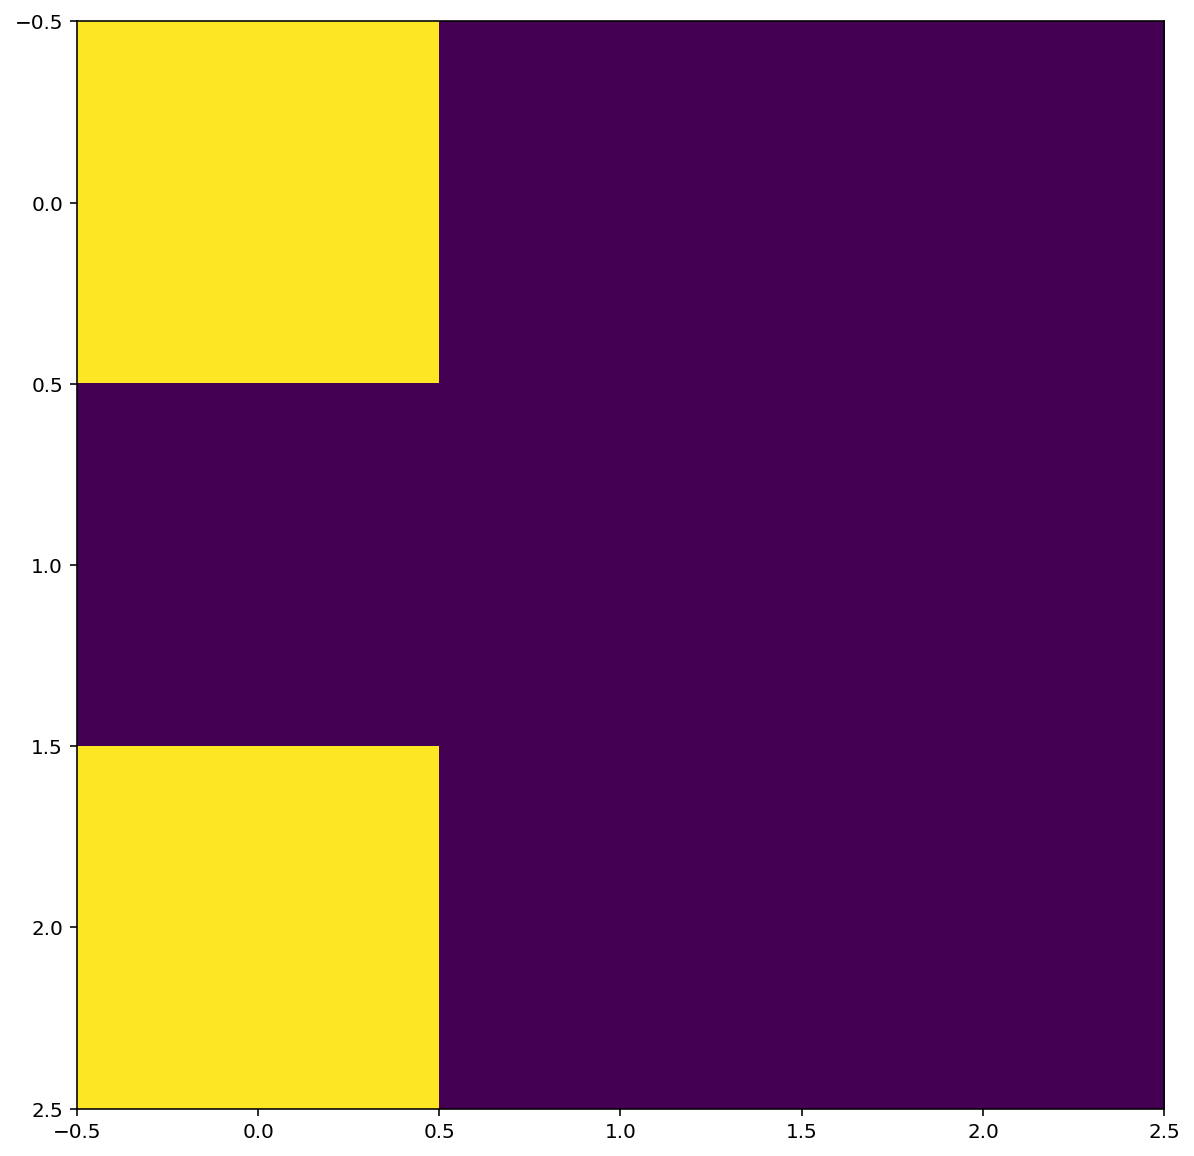

In [59]:
for channel in range(mask_history[0][0].shape[0]):
    for filters in range(mask_history[0][0].shape[-1]):
        plt.imshow(mask_history[0][0][channel,:,:,filters])

In [38]:
fcn_mask.layers[0].output

AttributeError: Layer conv_in has no inbound nodes.

In [297]:
x, layer_out = test(iter(ds_train_cif10).next()[0])

In [298]:
x

<tf.Tensor: shape=(128, 10), dtype=float32, numpy=
array([[0.10327648, 0.06267342, 0.05225683, ..., 0.11587001, 0.14315353,
        0.15664676],
       [0.10937632, 0.06725454, 0.05979786, ..., 0.11515807, 0.16146076,
        0.16512643],
       [0.09326565, 0.08717821, 0.05079903, ..., 0.11886841, 0.14460754,
        0.1451218 ],
       ...,
       [0.08943109, 0.08698727, 0.05388276, ..., 0.13217412, 0.1264147 ,
        0.15845174],
       [0.08496665, 0.09950992, 0.04160346, ..., 0.12306143, 0.15474327,
        0.1632188 ],
       [0.09280412, 0.07776964, 0.04430648, ..., 0.12087853, 0.15411909,
        0.16789721]], dtype=float32)>

In [238]:
iter(ds_train_mnist).next()[0].shape

TensorShape([128, 28, 28, 1])

In [239]:
iter(ds_train_cif10).next()[0].shape

TensorShape([128, 32, 32, 3])

In [53]:
mc = MaskedConv2D(filters=64, kernel_size=3, input_shape=INPUT_SHAPE, use_bias=False)

In [54]:
mc.out_shape

(128, 26, 13, 64)

In [55]:
mc.get_mask(as_logit=True)

<tf.Variable 'Variable:0' shape=(3, 3, 1, 64) dtype=float32, numpy=
array([[[[-4.30549085e-02, -9.87380147e-02,  8.25221166e-02,
          -5.88331930e-02, -3.56055461e-02,  2.41851844e-02,
           7.58366520e-03,  2.63399072e-02, -2.32688673e-02,
          -3.73841785e-02,  4.38836329e-02, -1.18723987e-02,
          -5.58252707e-02,  4.24915701e-02,  4.54991013e-02,
          -1.32199889e-02, -3.15771401e-02,  4.50575585e-03,
          -6.11123852e-02, -1.28976256e-02, -5.62764183e-02,
          -1.46060862e-04,  9.55470055e-02, -6.28002509e-02,
           5.77987023e-02,  1.61521230e-03,  4.45618900e-03,
          -1.70882940e-02,  1.01895267e-02,  6.32925890e-04,
           2.28676144e-02, -4.09628861e-02,  5.12597971e-02,
          -1.66248288e-02,  3.01541369e-02, -5.42329811e-02,
          -1.93796437e-02,  2.03722827e-02, -2.31280029e-02,
           5.82759641e-02, -1.18435398e-01,  5.78222536e-02,
          -3.14842276e-02,  6.86872527e-02,  3.39128301e-02,
          -9.8119

In [56]:
mc.set_weights

<bound method Layer.set_weights of <custom_nn.MaskedConv2D object at 0x7f446c048d90>>

In [57]:
3*3*1*64

576

In [58]:
mc.get_weights()

[array([[[[-4.30549085e-02, -9.87380147e-02,  8.25221166e-02,
           -5.88331930e-02, -3.56055461e-02,  2.41851844e-02,
            7.58366520e-03,  2.63399072e-02, -2.32688673e-02,
           -3.73841785e-02,  4.38836329e-02, -1.18723987e-02,
           -5.58252707e-02,  4.24915701e-02,  4.54991013e-02,
           -1.32199889e-02, -3.15771401e-02,  4.50575585e-03,
           -6.11123852e-02, -1.28976256e-02, -5.62764183e-02,
           -1.46060862e-04,  9.55470055e-02, -6.28002509e-02,
            5.77987023e-02,  1.61521230e-03,  4.45618900e-03,
           -1.70882940e-02,  1.01895267e-02,  6.32925890e-04,
            2.28676144e-02, -4.09628861e-02,  5.12597971e-02,
           -1.66248288e-02,  3.01541369e-02, -5.42329811e-02,
           -1.93796437e-02,  2.03722827e-02, -2.31280029e-02,
            5.82759641e-02, -1.18435398e-01,  5.78222536e-02,
           -3.14842276e-02,  6.86872527e-02,  3.39128301e-02,
           -9.81193259e-02,  8.59625861e-02, -1.50663659e-01,
        

In [59]:
mc.get_weights()

[array([[[[-4.30549085e-02, -9.87380147e-02,  8.25221166e-02,
           -5.88331930e-02, -3.56055461e-02,  2.41851844e-02,
            7.58366520e-03,  2.63399072e-02, -2.32688673e-02,
           -3.73841785e-02,  4.38836329e-02, -1.18723987e-02,
           -5.58252707e-02,  4.24915701e-02,  4.54991013e-02,
           -1.32199889e-02, -3.15771401e-02,  4.50575585e-03,
           -6.11123852e-02, -1.28976256e-02, -5.62764183e-02,
           -1.46060862e-04,  9.55470055e-02, -6.28002509e-02,
            5.77987023e-02,  1.61521230e-03,  4.45618900e-03,
           -1.70882940e-02,  1.01895267e-02,  6.32925890e-04,
            2.28676144e-02, -4.09628861e-02,  5.12597971e-02,
           -1.66248288e-02,  3.01541369e-02, -5.42329811e-02,
           -1.93796437e-02,  2.03722827e-02, -2.31280029e-02,
            5.82759641e-02, -1.18435398e-01,  5.78222536e-02,
           -3.14842276e-02,  6.86872527e-02,  3.39128301e-02,
           -9.81193259e-02,  8.59625861e-02, -1.50663659e-01,
        

In [60]:
mc.trainable_weights

[<tf.Variable 'Variable:0' shape=(3, 3, 1, 64) dtype=float32, numpy=
 array([[[[-4.30549085e-02, -9.87380147e-02,  8.25221166e-02,
           -5.88331930e-02, -3.56055461e-02,  2.41851844e-02,
            7.58366520e-03,  2.63399072e-02, -2.32688673e-02,
           -3.73841785e-02,  4.38836329e-02, -1.18723987e-02,
           -5.58252707e-02,  4.24915701e-02,  4.54991013e-02,
           -1.32199889e-02, -3.15771401e-02,  4.50575585e-03,
           -6.11123852e-02, -1.28976256e-02, -5.62764183e-02,
           -1.46060862e-04,  9.55470055e-02, -6.28002509e-02,
            5.77987023e-02,  1.61521230e-03,  4.45618900e-03,
           -1.70882940e-02,  1.01895267e-02,  6.32925890e-04,
            2.28676144e-02, -4.09628861e-02,  5.12597971e-02,
           -1.66248288e-02,  3.01541369e-02, -5.42329811e-02,
           -1.93796437e-02,  2.03722827e-02, -2.31280029e-02,
            5.82759641e-02, -1.18435398e-01,  5.78222536e-02,
           -3.14842276e-02,  6.86872527e-02,  3.39128301e-02,
 

In [61]:
mc.non_trainable_weights

[<tf.Variable 'Variable:0' shape=(3, 3, 1, 64) dtype=float32, numpy=
 array([[[[ 0.06524039,  0.09070961, -0.03392106, -0.03798829,
            0.00492183,  0.01082622,  0.03999299,  0.02317412,
           -0.07749361,  0.00782654,  0.05761006, -0.05228462,
            0.01083441,  0.05870349,  0.07531562, -0.01971643,
           -0.02830264, -0.05419139,  0.08978821,  0.0461692 ,
           -0.01633086,  0.00431861, -0.01476197, -0.07867516,
           -0.0823853 , -0.08116492,  0.06094109,  0.04125399,
           -0.01254446,  0.01463621, -0.00706716, -0.03315062,
           -0.01356845,  0.00458248, -0.03665462, -0.03141736,
           -0.0371236 , -0.02497433, -0.01197346, -0.01053368,
           -0.04889293,  0.08293208,  0.02135742, -0.09017786,
            0.05083613, -0.02987114,  0.05883196, -0.00384949,
            0.03139707, -0.10422887, -0.01353978,  0.01707678,
           -0.0919968 , -0.01707014,  0.00794747, -0.0366854 ,
            0.01270528, -0.05380801, -0.04542204,

In [62]:
test = tf.cast(iter(ds_train_mnist).next()[0], tf.float32)

In [63]:
test.shape

TensorShape([128, 28, 28, 1])

In [64]:
mc(test)

UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above. [Op:Conv2D]

In [252]:
mc.out_shape

(128, 30, 15, 64)

In [253]:
test_maxpool = MaxPool2DExt(input_shape = mc.out_shape, pool_size=(2, 2), strides=None, padding='valid', data_format=None)

In [254]:
test_maxpool.out_shape

(128, 15, 7, 64)

In [255]:
MaxPool2DExt(input_shape = mc.out_shape, pool_size=(2, 2), strides=None, padding='valid', data_format=None
)(mc(test))

Shape mask:  (3, 3, 3, 64)
kernel shape:  (3, 3, 3, 64)
input type:  <dtype: 'float32'>
kernel type:  <dtype: 'float32'>


<tf.Tensor: shape=(128, 15, 7, 64), dtype=float32, numpy=
array([[[[-1.96953103e-01,  4.57083294e-03, -4.06591818e-02, ...,
           1.24540702e-01,  1.31059168e-02, -2.21784711e-02],
         [-1.76682308e-01,  1.12280967e-02, -4.10067551e-02, ...,
           1.21692300e-01,  1.97234582e-02, -3.07511184e-02],
         [-1.50002584e-01,  2.45225411e-02, -3.70416790e-02, ...,
           1.82082012e-01,  4.48386930e-02, -1.16773844e-02],
         ...,
         [-1.29290432e-01,  1.41991386e-02, -1.97706446e-02, ...,
           9.98345837e-02,  3.36731412e-02, -2.21954454e-02],
         [-1.14069469e-01,  1.04040215e-02, -2.69249752e-02, ...,
           8.74431729e-02,  1.31684160e-02, -3.14040221e-02],
         [-7.02040419e-02,  8.39326810e-03, -8.12536012e-03, ...,
           6.75963312e-02,  2.47040242e-02, -1.52848270e-02]],

        [[-1.69056758e-01,  8.25486425e-03, -3.15850228e-02, ...,
           9.88578498e-02,  2.46816091e-02, -4.65485938e-02],
         [-1.90339148e-01,  3.

In [82]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [256]:
a = (4,3,2,1)

In [257]:
import tensorflow as tf
tf.math.reduce_prod(a)

<tf.Tensor: shape=(), dtype=int32, numpy=24>